In [ ]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
drive='/content/gdrive/My Drive/python/COLING25_academic_essay_auth_challenge/'
os.chdir(drive)

In [ ]:
!pip install -q nela_features

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.9 MB/s eta 0:00:00


In [ ]:
def go_home_dir():
  drive='/content/gdrive/My Drive/python/COLING25_academic_essay_auth_challenge/'
  os.chdir(drive)
  print("Current directory is {}".format(os.getcwd()))

In [ ]:
def go_to_dir(path=drive):
  #drive='/content/gdrive/My Drive/python/COLING25_academic_essay_auth_challenge/'
  os.chdir(path)
  print("Current directory is {}".format(os.getcwd()))

In [ ]:
!ls

academic_essay_english_dev.jsonl		genai-content-detection-coling-2025
academic_essay_english_dev_test_no_label.jsonl	task.tsv
academic_essay_english_train.jsonl		task.zip
english_essay_test_without_label.jsonl		X_train_nela_features.pkl
final_classifier.pkl				X_val_nela_features.pkl


In [ ]:
import pandas as pd

In [ ]:
train_filename = 'academic_essay_english_train.jsonl'
dev_filename = 'academic_essay_english_dev.jsonl'
test_filename = 'english_essay_test_without_label.jsonl'
train_df = pd.read_json(train_filename, lines=True)
dev_df = pd.read_json(dev_filename, lines=True)
test_df = pd.read_json(test_filename, lines=True)
print(train_df)
print(dev_df)
print(test_df)

                                                     id  \
0     cc7727e8bfbc6e0051b71ceeeb928755def0f5e94b5168...   
1     fa7e1bc99ea20c78df905eb3780cb835bed078b64fce6a...   
2     d16ec17f6ffd059cf2eefe79ca2ccd9bdb78ea5ec2d6a0...   
3     838f538cf1b0e03e51e423266844492af1a72874a224d4...   
4     cd9fe478b001e04bcdc276f9675b90bc8c6332a7ea8abf...   
...                                                 ...   
2091  1cf89b43ddf6f54c41ce5ff8d584dd47fbe21fc9007048...   
2092  90aeae7d7df06d9e45cff4494973ad4cc668aa92f395b7...   
2093  a6ac8461fe6b71161372b63438d531af3168e3f4c5ce1c...   
2094  a0bf652b04c7f6fdfea48ccabcc853aa21c832ce749257...   
2095  21847eeb48b24217c3c17297c1d7ea3856d234e5c76ae2...   

                                                  essay  label  
0     I disagree with the statement that the develop...     ai  
1     I disagree with the statement that the primary...     ai  
2     International sports events require the most w...  human  
3     While some individuals ma

In [ ]:
# Check if there are any common ids in train and dev
train_ids = set(train_df['id'])
dev_ids = set(dev_df['id'])
common_ids = train_ids.intersection(dev_ids)
print(common_ids)

set()


In [ ]:
# Check if there are common essays in train and dev
train_essays = set(train_df['essay'])
dev_essays = set(dev_df['essay'])
common_essays = train_essays.intersection(dev_essays)
print(len(common_essays))

0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


label_to_num= {"human": 0, "ai": 1}
train_texts = train_df['essay'].values
train_labels = train_df['label']

train_labels = [label_to_num[train_label] for train_label in train_labels.values]

val_texts = dev_df['essay'].values
val_labels = dev_df['label']

val_labels = [label_to_num[val_label] for val_label in val_labels.values]

In [ ]:
train_labels.count(0), train_labels.count(1), len(train_labels)

(629, 1467, 2096)

In [ ]:
val_labels.count(0), val_labels.count(1), len(val_labels)

(1235, 391, 1626)

In [ ]:
train_df['label'].value_counts()

,count
label,
ai,1467
human,629


In [ ]:
dev_df['label'].value_counts()

,count
label,
human,1235
ai,391


In [ ]:
# simple vanilla params
vectorizer = TfidfVectorizer()
print("Fitting vectorizer...")
train_vectors = vectorizer.fit_transform(train_texts)
print("Transforming text to vectors")
val_vectors = vectorizer.transform(val_texts)
print("Samples in training set: ", train_vectors.shape[0])
print("Features in training set: ", train_vectors.shape[1])
print("Samples in validation set: ", val_vectors.shape[0])
print("Features in validation set: ", val_vectors.shape[1])

# Do classification with logistic regression
classifier = LogisticRegression()
print("Fitting LR classifier...")
classifier.fit(train_vectors, train_labels)
score = classifier.score(val_vectors, val_labels)
print('Logistic Regression Score:', score)
predictions = classifier.predict(val_vectors)
print('Logistic Regression Accuracy:', accuracy_score(val_labels, predictions))
print('Logistic Regression Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting vectorizer...
Transforming text to vectors
Samples in training set:  2096
Features in training set:  12043
Samples in validation set:  1626
Features in validation set:  12043
Fitting LR classifier...
Logistic Regression Score: 0.9292742927429274
Logistic Regression Accuracy: 0.9292742927429274
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     0.9148    1.0000    0.9555      1235
           1     1.0000    0.7059    0.8276       391

    accuracy                         0.9293      1626
   macro avg     0.9574    0.8529    0.8915      1626
weighted avg     0.9353    0.9293    0.9248      1626



In [ ]:
vectorizer = TfidfVectorizer(min_df=5,max_features=200,
                             strip_accents='unicode',analyzer='word',
                             token_pattern=r'\w{1,}',ngram_range=(1,2),
                             use_idf=True, smooth_idf=True,stop_words='english',
                             )
print("Fitting vectorizer...")
train_vectors = vectorizer.fit_transform(train_texts)
print("Transforming text to vectors")
val_vectors = vectorizer.transform(val_texts)
print("Samples in training set: ", train_vectors.shape[0])
print("Features in training set: ", train_vectors.shape[1])
print("Samples in validation set: ", val_vectors.shape[0])
print("Features in validation set: ", val_vectors.shape[1])

# Do classification with logistic regression
classifier = LogisticRegression()
print("Fitting LR classifier...")
classifier.fit(train_vectors, train_labels)
score = classifier.score(val_vectors, val_labels)
print('Logistic Regression Score:', score)
predictions = classifier.predict(val_vectors)
print('Logistic Regression Accuracy:', accuracy_score(val_labels, predictions))
print('Logistic Regression Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting vectorizer...
Transforming text to vectors
Samples in training set:  2096
Features in training set:  200
Samples in validation set:  1626
Features in validation set:  200
Fitting LR classifier...
Logistic Regression Score: 0.9661746617466175
Logistic Regression Accuracy: 0.9661746617466175
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     0.9617    0.9951    0.9781      1235
           1     0.9828    0.8747    0.9256       391

    accuracy                         0.9662      1626
   macro avg     0.9722    0.9349    0.9518      1626
weighted avg     0.9667    0.9662    0.9655      1626



In [ ]:
# This is required for nela features to work
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [ ]:
# This cell is to print the feature names
from nela_features.nela_features import NELAFeatureExtractor

newsarticle = "Breaking News: Ireland Expected To Become World's First Country To Divest From Fossil Fuels ..."

nela = NELAFeatureExtractor()

# Extract all feature groups at once
feature_vector, feature_names = nela.extract_all(newsarticle)
print(feature_vector)
print("#all features=", len(feature_names))
print("ALL FEATURE NAMES=", feature_names)
print("==="*10)

# Extract each feature group independently
feature_vector, feature_names = nela.extract_style(newsarticle)
print("#style features=", len(feature_names))
print("STYLE FEATURE NAMES=", feature_names)
print("==="*10)

feature_vector, feature_names = nela.extract_complexity(newsarticle)
print("#complexity features=", len(feature_names))
print("COMPLEXITY FEATURE NAMES=", feature_names)
print("==="*10)

feature_vector, feature_names = nela.extract_bias(newsarticle)
print("#bias features=", len(feature_names))
print("BIAS FEATURE NAMES=", feature_names)
print("==="*10)

feature_vector, feature_names = nela.extract_affect(newsarticle)
print("#affect features=", len(feature_names))
print("AFFECT FEATURE NAMES=", feature_names)
print("==="*10)

feature_vector, feature_names = nela.extract_moral(newsarticle)
print("#moral features=", len(feature_names))
print("MORAL FEATURE NAMES=", feature_names)
print("==="*10)

feature_vector, feature_names = nela.extract_event(newsarticle)
print("#event features=", len(feature_names))
print("EVENT FEATURE NAMES=", feature_names)
print("==="*10)

[0.0, 0.0, 0.058823529411764705, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13333333333333333, 0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.06666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9333333333333333, 5.066666666666666, 15, -2.6836, 3.0, 12.0427, 41.66666666666667, 0.06666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
#all features= 87
ALL FEATURE NAMES= ['quotes', 'exclaim', 'allpunc', 'allcaps', 'stops', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'WP$', 'WRB', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', '$', "''", '(', ')', ',', '--', '.', ':', '``', 'ttr', 'avg_wordlen', 'word_count', 'flesc

In [ ]:
from nltk.corpus import stopwords
stopwords_eng = set(stopwords.words('english'))
print(stopwords_eng)

{'most', 'theirs', 'were', "aren't", 'they', 'mightn', 'more', 'shan', 'her', 'should', "doesn't", 'our', "you're", 'any', 'if', 'once', 'very', 'to', 'ain', "isn't", "didn't", 'm', 'at', 'no', 'just', "she's", 'myself', 'by', 'during', 'ours', 'was', 'down', 't', 'hadn', 'only', "that'll", 'themselves', 'he', 'my', 'been', 'don', 'y', 'himself', "mustn't", 'needn', 'such', 'weren', 'wouldn', 'that', "weren't", "it's", 'same', 'your', 'isn', 'own', 'than', 'be', 'can', 'but', 'out', 'being', 'of', 'we', "needn't", 'do', 'shouldn', 'has', 'and', 'before', 'doing', 'all', "you'd", 'haven', 'too', 'as', 'll', 'o', 'having', "hasn't", 'into', 'hasn', 'off', 'mustn', 'then', 'why', 'through', 'now', 'other', 'have', 'a', 'below', 'with', 'until', 'ourselves', 'again', 'will', 'under', 'its', 'after', 'wasn', 'up', "won't", 'herself', 'couldn', 'each', 'yourselves', 'me', 'itself', 'ma', 'doesn', 'where', "should've", 'is', 'above', 'further', 'am', 'him', 'his', 'how', 'for', 'on', 'here', 

In [ ]:
test_sentence = "there is a simple answer there"

nela = NELAFeatureExtractor()

# Extract all feature groups at once
feature_vector, feature_names = nela.extract_all(test_sentence)
print(feature_vector)

[0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 0.16666666666666666, 0.3333333333333333, 0.0, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8333333333333334, 4.166666666666667, 6, -7.881, 3.0, 3.7417, 6.0, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
from nela_features.nela_features import NELAFeatureExtractor
nela = NELAFeatureExtractor()

In [ ]:
from tqdm import tqdm
X_train = [nela.extract_all(X)[0] for X in tqdm(train_texts)]
X_val = [nela.extract_all(X)[0] for X in tqdm(val_texts)]
print(len(X_train), len(X_val))
print(X_train[0], X_val[0])

100%|██████████| 1626/1626 [19:50<00:00,  1.37it/s]

2096 1626
[0.0, 0.0, 0.07951070336391437, 0.03669724770642202, 0.42201834862385323, 0.036544850498338874, 0.0033222591362126247, 0.08970099667774087, 0.0, 0.0, 0.1461794019933555, 0.08637873754152824, 0.013289036544850499, 0.0, 0.0, 0.04983388704318937, 0.09302325581395349, 0.12624584717607973, 0.03986710963455149, 0.0, 0.0, 0.0, 0.019933554817275746, 0.006644518272425249, 0.053156146179401995, 0.009966777408637873, 0.0, 0.0033222591362126247, 0.0, 0.036544850498338874, 0.0, 0.0, 0.0, 0.07641196013289037, 0.0, 0.013289036544850499, 0.023255813953488372, 0.036544850498338874, 0.019933554817275746, 0.009966777408637873, 0.006644518272425249, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.49169435215946844, 4.840531561461794, 301, 1.2866, 14.291589790636214, 11.5147, 48.67137320044297, 0.11295681063122924, 0.009966777408637873, 0.0, 0.016611295681063124, 0.006644518272425249, 0.006644518272425249, 0.05647840531561462, 0.016611295681063124, 0.062, 0.798, 0.14, 0.019933554817275746, 0.06312

In [ ]:
#Save the X_train and X_val as pickle files
import pickle
with open('X_train_nela_features.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('X_val_nela_features.pkl', 'wb') as f:
    pickle.dump(X_val, f)

In [ ]:
# Load the pickle files when required
import pickle
with open('X_train_nela_features.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('X_val_nela_features.pkl', 'rb') as f:
    X_val = pickle.load(f)

(2096, 2)


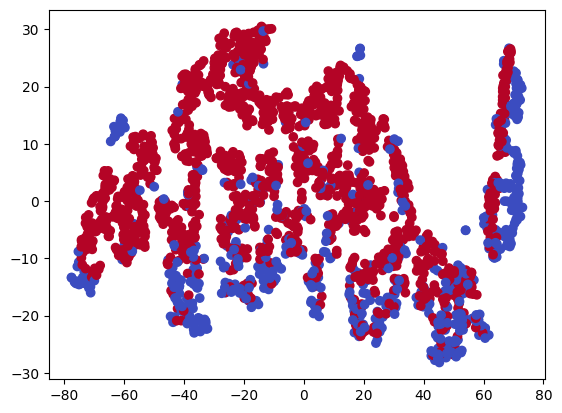

In [ ]:
# Plot the tsne for X_train and y_train
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
tsne = TSNE(n_components=2, random_state=0)
X_train_tsne = tsne.fit_transform(X_train)
print(X_train_tsne.shape)
# Display the tsne image, use red and green colors
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=train_labels, cmap='coolwarm')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.show()

In [ ]:
classifier = LogisticRegression()
print("Fitting LR classifier...")
classifier.fit(X_train, train_labels)
score = classifier.score(X_val, val_labels)
print('Logistic Regression Score:', score)
predictions = classifier.predict(X_val)
print('Logistic Regression Accuracy:', accuracy_score(val_labels, predictions))
print('Logistic Regression Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting LR classifier...
Logistic Regression Score: 0.9932349323493235
Logistic Regression Accuracy: 0.9932349323493235
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     0.9976    0.9935    0.9955      1235
           1     0.9798    0.9923    0.9860       391

    accuracy                         0.9932      1626
   macro avg     0.9887    0.9929    0.9908      1626
weighted avg     0.9933    0.9932    0.9932      1626



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Train the model using random forest
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
print("Fitting RF classifier...")
classifier.fit(X_train, train_labels)
score = classifier.score(X_val, val_labels)
print('Random Forest Score:', score)
predictions = classifier.predict(X_val)
print('Random Forest Accuracy:', accuracy_score(val_labels, predictions))
print('Random Forest Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting RF classifier...
Random Forest Score: 0.993849938499385
Random Forest Accuracy: 0.993849938499385
Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.9960    0.9960    0.9960      1235
           1     0.9872    0.9872    0.9872       391

    accuracy                         0.9938      1626
   macro avg     0.9916    0.9916    0.9916      1626
weighted avg     0.9938    0.9938    0.9938      1626



In [ ]:
importances = classifier.feature_importances_

# Create a DataFrame to organize feature names and their importances
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted DataFrame
# Show all rows in the pandas dataframe
pd.set_option('display.max_rows', None)
print(importance_df)

                       Feature  Importance
4                        stops    0.095658
51                 avg_wordlen    0.070496
2                      allpunc    0.058219
55          coleman_liau_index    0.055857
56                         lix    0.054743
8                           EX    0.050096
54                  smog_index    0.046586
5                           CC    0.041913
53  flesch_kincaid_grade_level    0.041329
50                         ttr    0.038575
69                        wpos    0.038066
3                      allcaps    0.028260
63      positive_opinion_words    0.024335
70                        wneu    0.021789
11                          JJ    0.021494
25                         RBR    0.020548
67                      vadpos    0.018963
7                           DT    0.018004
73                        sneu    0.013442
13                         JJS    0.013213
24                          RB    0.012982
84             MoralityGeneral    0.011533
61         

### RERUN THIS FOR ERROR ANALYSIS

In [ ]:
# Fit an extratree classifier
# This is the final model to be used. But it has to be trained on the total dataset
from sklearn.ensemble import ExtraTreesClassifier
classifier = ExtraTreesClassifier()
print("Fitting ET classifier...")
classifier.fit(X_train, train_labels)
score = classifier.score(X_val, val_labels)
print('Extra Trees Score:', score)
predictions = classifier.predict(X_val)
print('Extra Trees Accuracy:', accuracy_score(val_labels, predictions))
print('Extra Trees Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting ET classifier...
Extra Trees Score: 0.996309963099631
Extra Trees Accuracy: 0.996309963099631
Extra Trees Classification Report:
              precision    recall  f1-score   support

           0     0.9984    0.9968    0.9976      1235
           1     0.9898    0.9949    0.9923       391

    accuracy                         0.9963      1626
   macro avg     0.9941    0.9958    0.9950      1626
weighted avg     0.9963    0.9963    0.9963      1626



<Axes: >

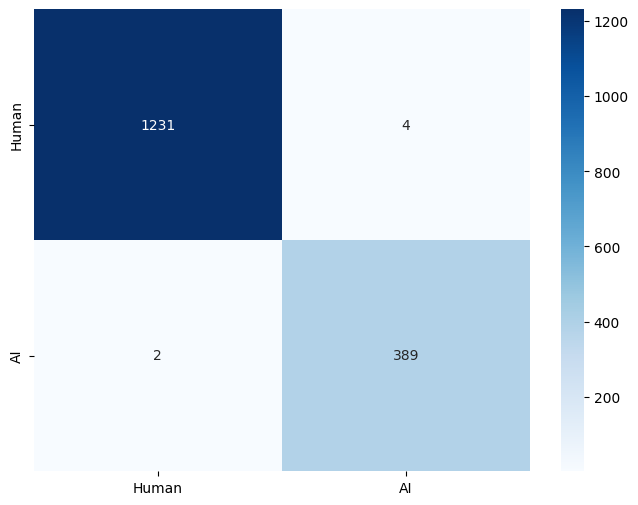

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
cm = confusion_matrix(val_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])

In [ ]:
# Do analysis of errors
for val_text, pred, truth in zip(val_texts,predictions, val_labels):
  if pred != truth:
    print("Predicted: {}, Truth: {}".format(pred, truth))
    print(val_text)
    print("==="*10)

Predicted: 0, Truth: 1
The statement that successful people try new things and take risks rather than only doing what they already know how to do well holds a great deal of truth. While mastering existing skills is important, embracing novelty and stepping outside of comfort zones often leads to greater achievements and personal growth. 

One compelling example is the story of J.K. Rowling. Before publishing the Harry Potter series, she was a struggling single mother with a degree in French and Classics. Taking a risk, she decided to pursue her passion for writing, a field she had no prior experience in. This bold move, fueled by her creativity and willingness to try something new, led to the creation of a global phenomenon that has captivated millions.

Furthermore, the world of business is filled with examples of successful entrepreneurs who took calculated risks. Steve Jobs, for instance, was famously fired from Apple, the company he co-founded. Instead of dwelling on his setback, h

In [ ]:
!pip install xgboost

In [ ]:
# Train a XGBoost Classifier
from xgboost import XGBClassifier
classifier = XGBClassifier()
print("Fitting XGBoost classifier...")
classifier.fit(X_train, train_labels)
score = classifier.score(X_val, val_labels)
print('XGBoost Score:', score)
predictions = classifier.predict(X_val)
print('XGBoost Accuracy:', accuracy_score(val_labels, predictions))
print('XGBoost Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting XGBoost classifier...
XGBoost Score: 0.9710947109471094
XGBoost Accuracy: 0.9710947109471094
XGBoost Classification Report:
              precision    recall  f1-score   support

           0     0.9925    0.9692    0.9807      1235
           1     0.9095    0.9770    0.9420       391

    accuracy                         0.9711      1626
   macro avg     0.9510    0.9731    0.9614      1626
weighted avg     0.9726    0.9711    0.9714      1626



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_feature_graph(feature_index, feature_name, X_train, y_train):
  # Assuming X_train and y_train are already defined
  # X_train has shape (M, N) and y_train has shape (M,)
  X_train = np.array(X_train)
  y_train = np.array(train_labels)
  # Extract the first feature from X_train
  first_feature = X_train[:, feature_index]

  # Separate the first feature values based on the classes in y_train
  positive_class = first_feature[y_train == 1]
  negative_class = first_feature[y_train == 0]

  # Plot the histograms with normalization to show percentages
  plt.figure(figsize=(10, 6))
  plt.hist(
      positive_class,
      bins=100,
      alpha=0.7,
      label="AI Generated",
      color="blue",
      edgecolor="black",
      weights=np.ones(len(positive_class)) / len(positive_class) * 100,
  )
  plt.hist(
      negative_class,
      bins=100,
      alpha=0.7,
      label="Human Written",
      color="red",
      edgecolor="black",
      weights=np.ones(len(negative_class)) / len(negative_class) * 100,
  )

  # Add labels and legend
  plt.title("Histogram of the feature {}  ({})".format(feature_name, feature_index))
  plt.xlabel("Feature Value")
  plt.ylabel("Percentage of samples(%)")
  plt.legend()
  #plt.grid(axis="y", linestyle="--", alpha=0.7)
  plt.show()

In [ ]:
feature_vector, all_feature_names = nela.extract_all(newsarticle)

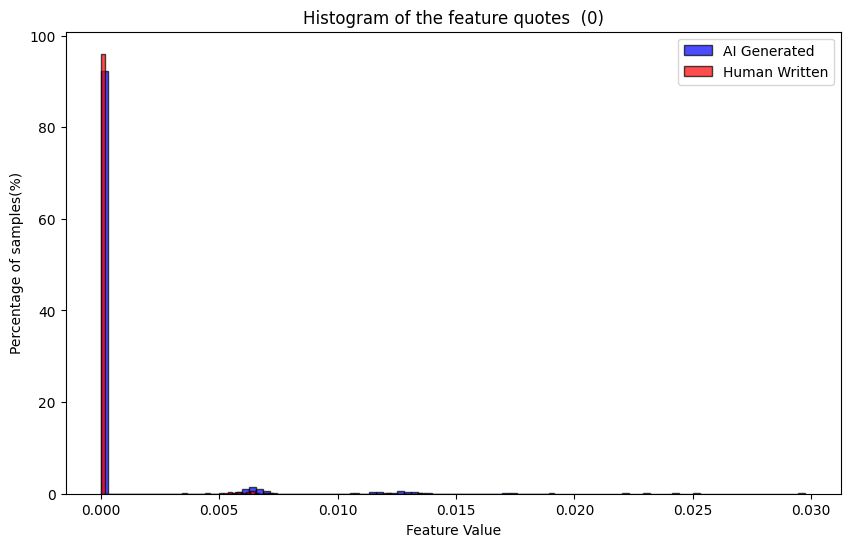

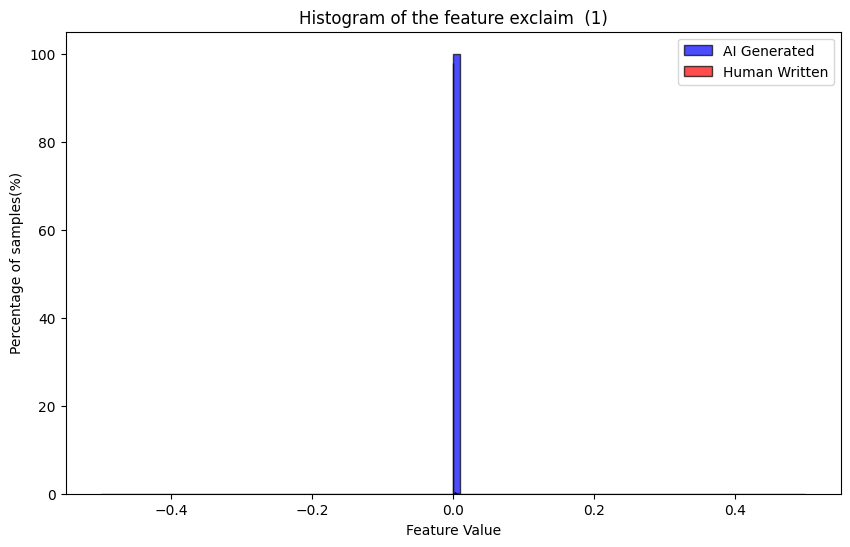

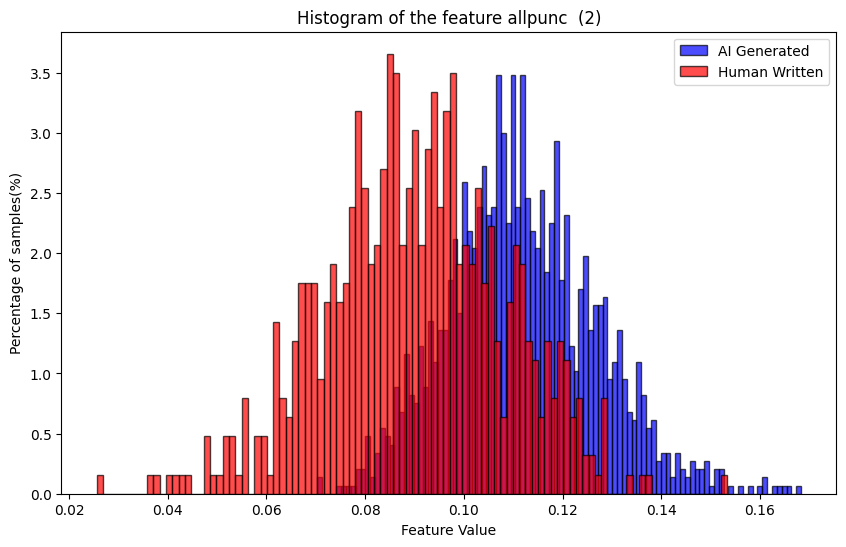

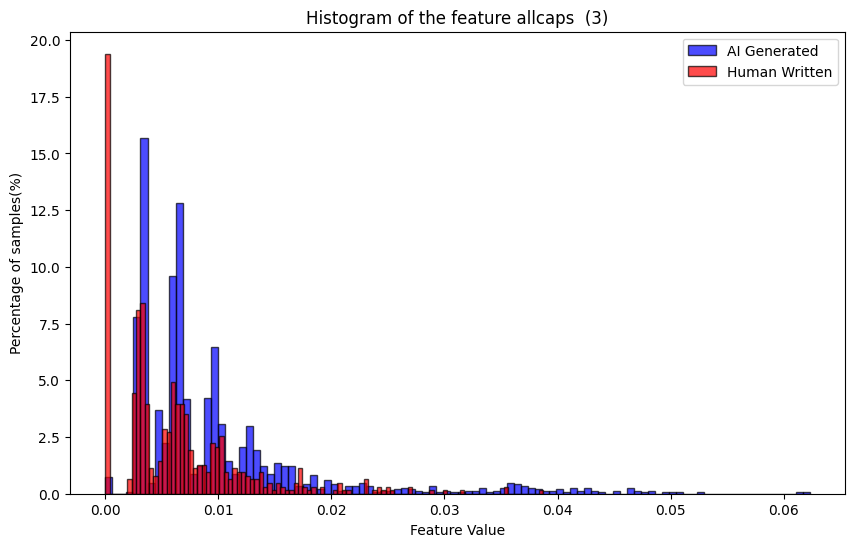

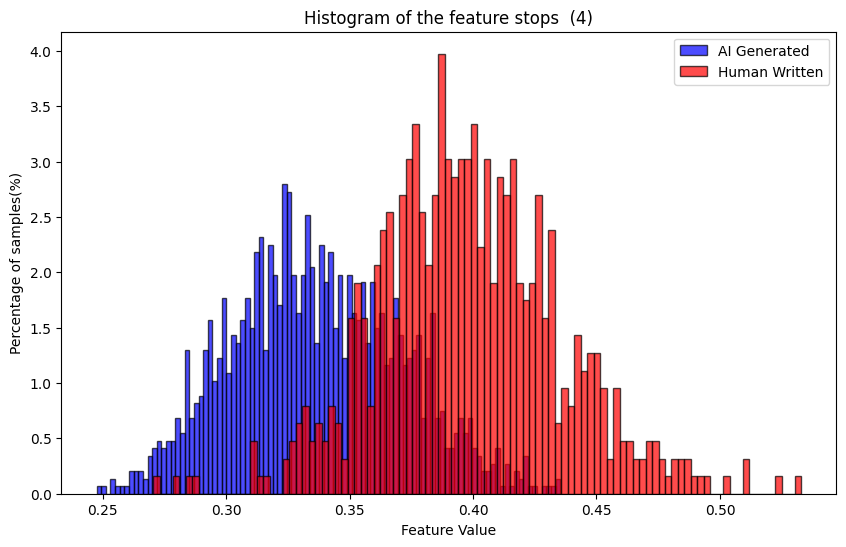

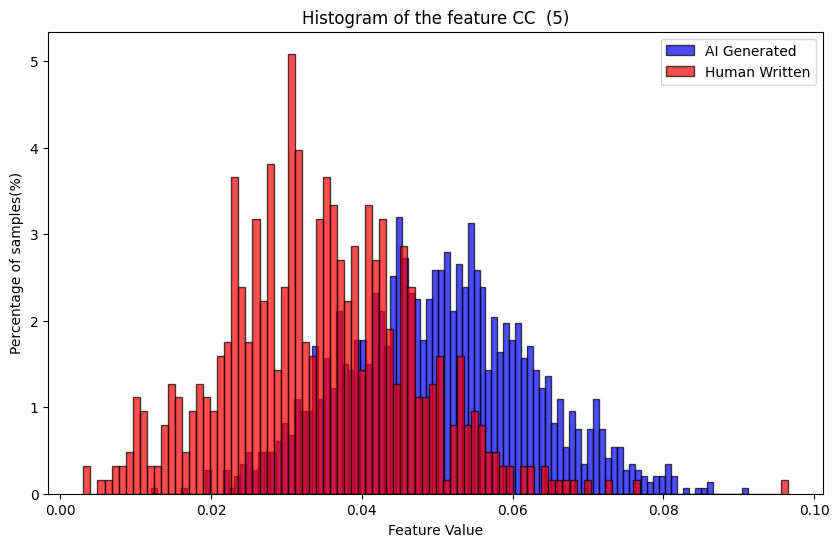

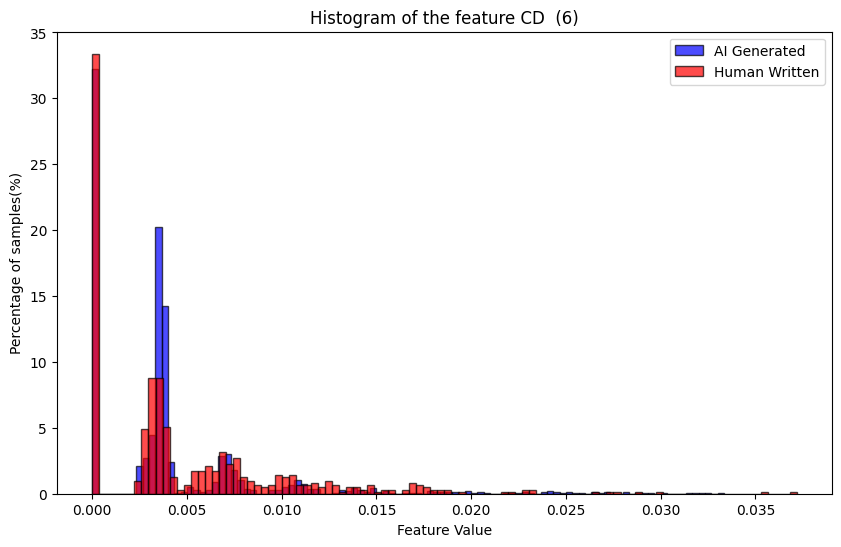

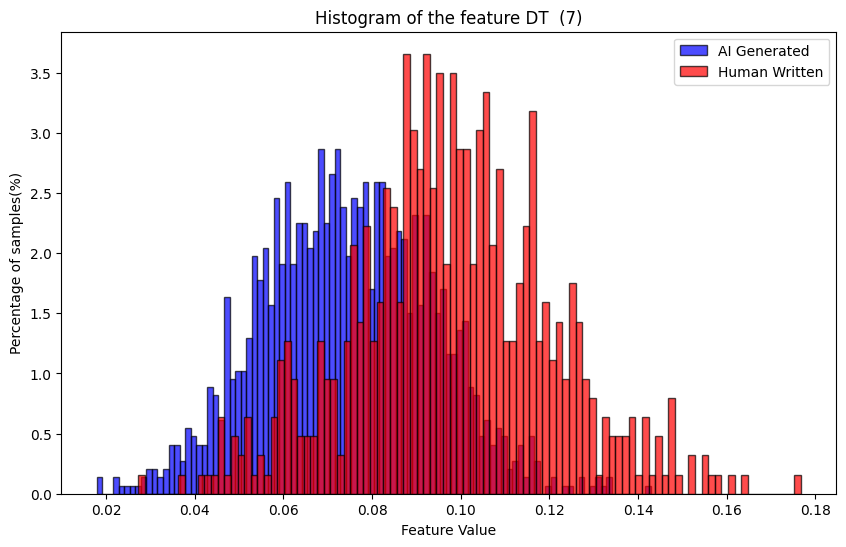

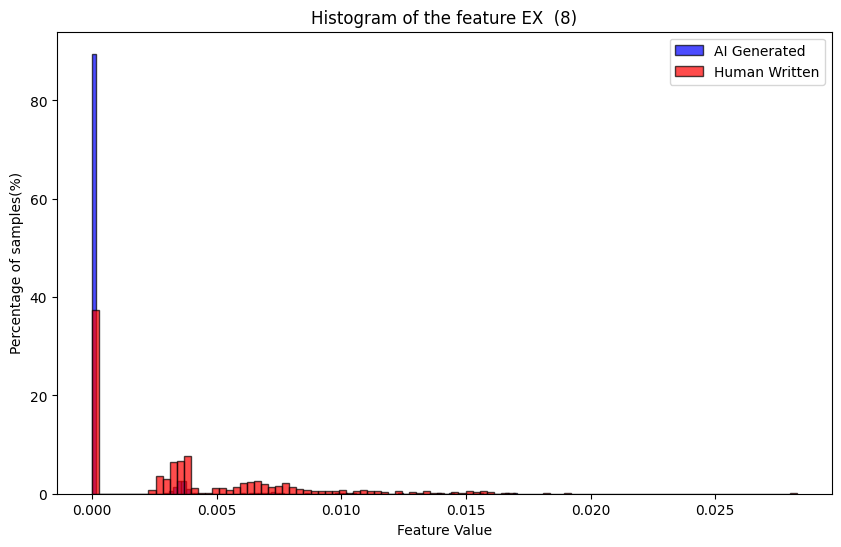

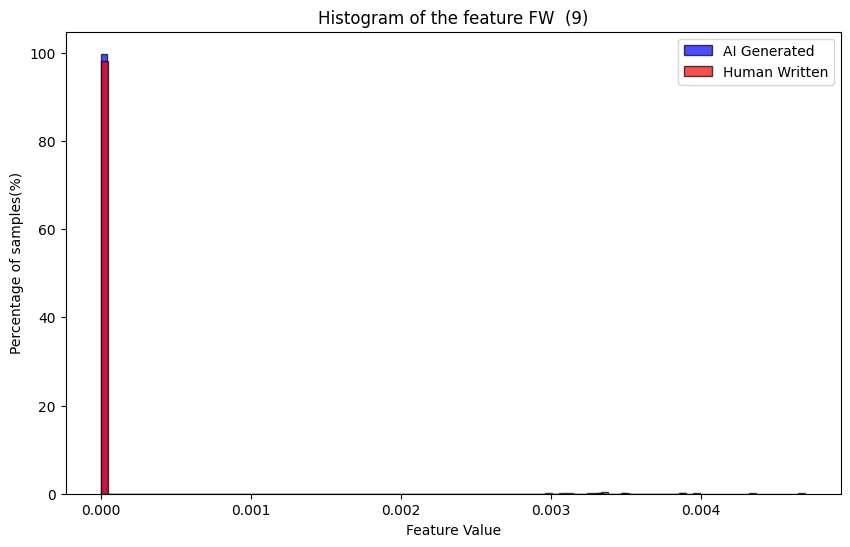

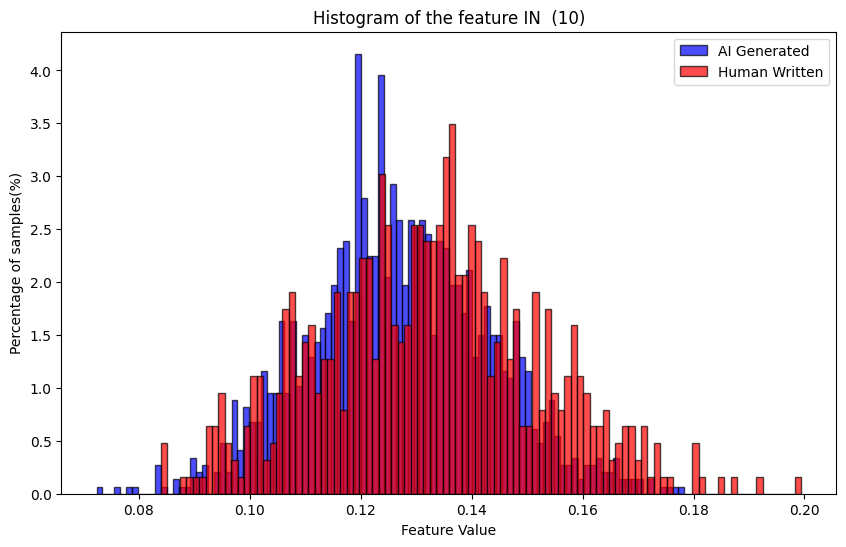

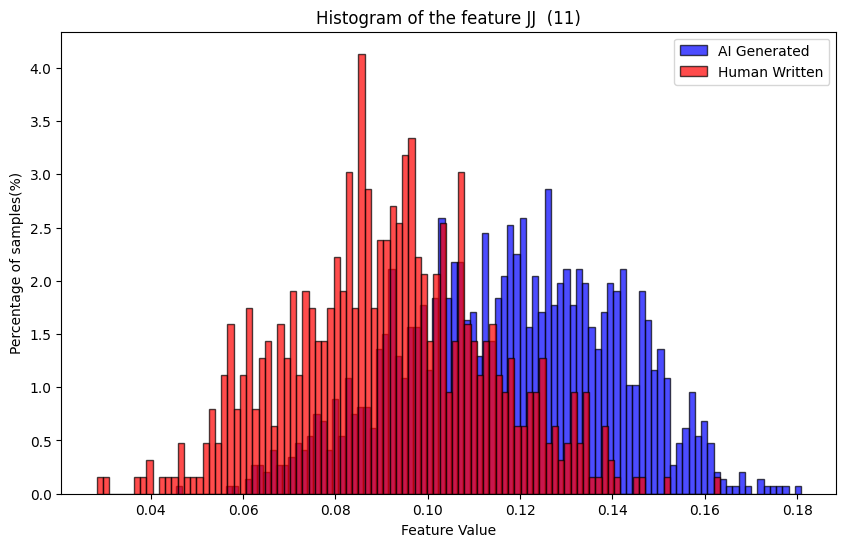

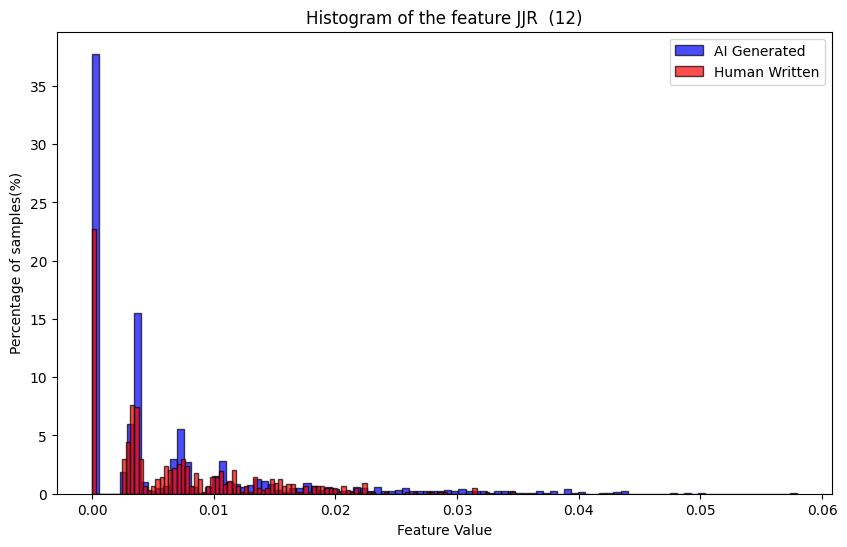

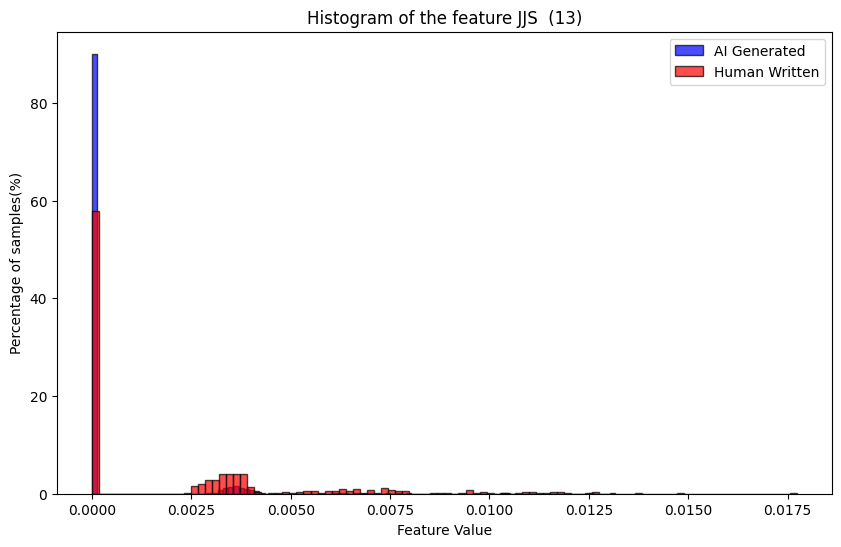

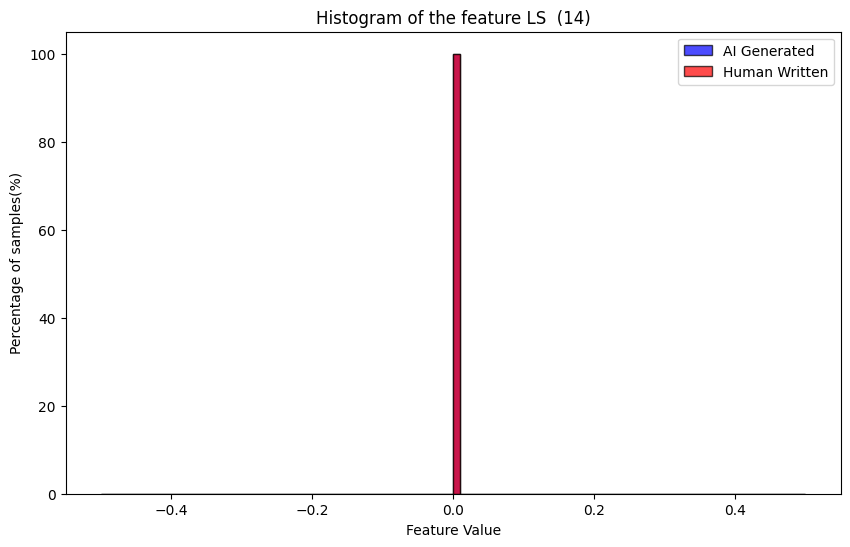

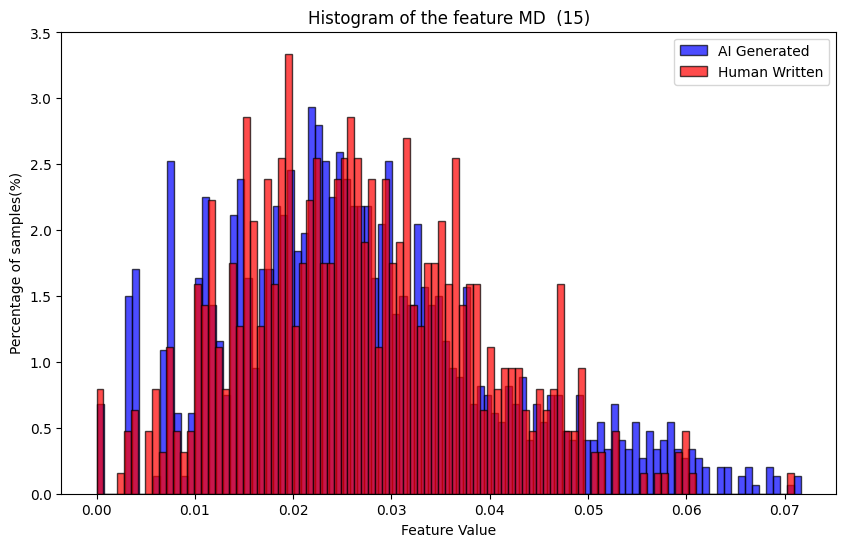

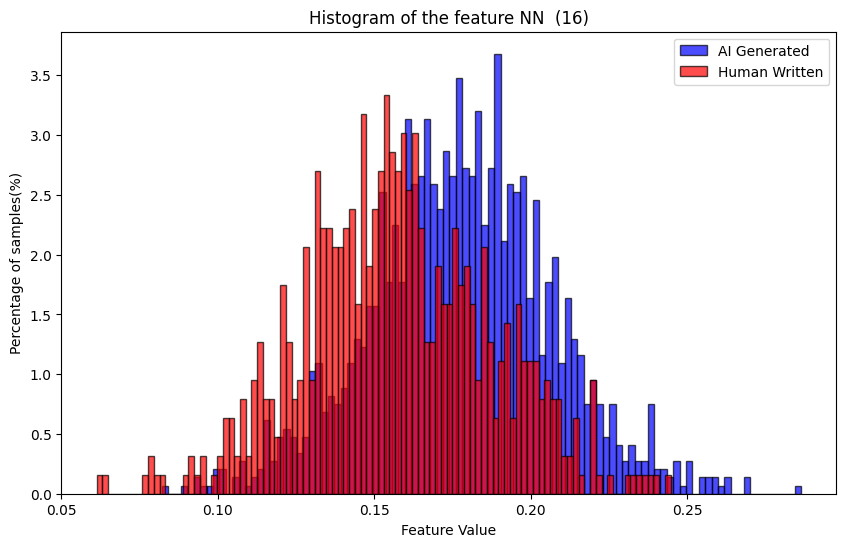

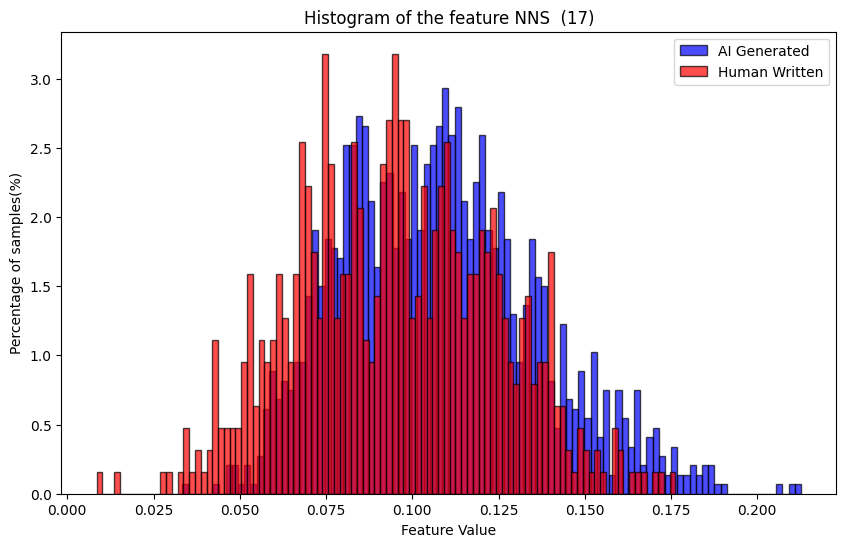

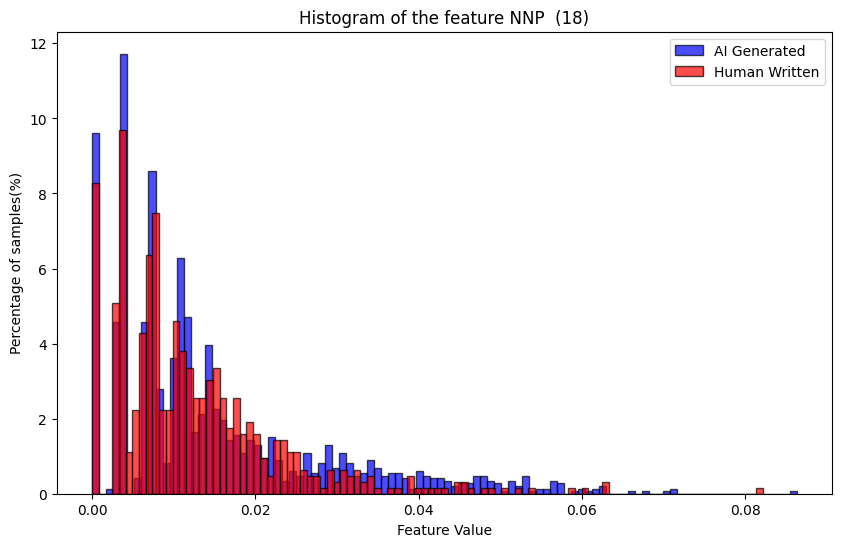

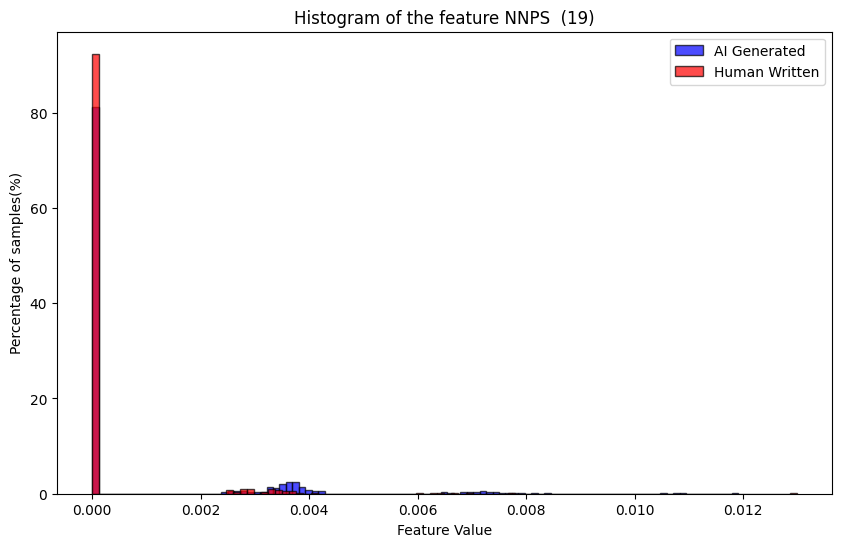

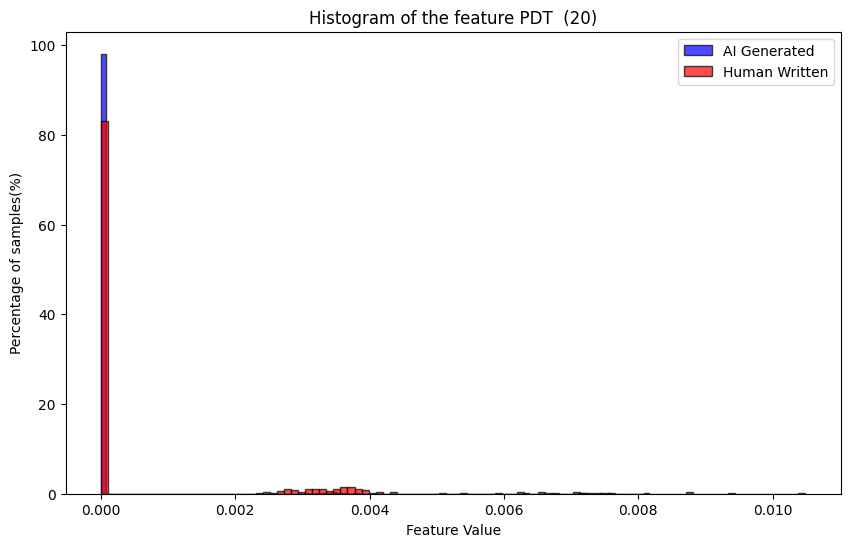

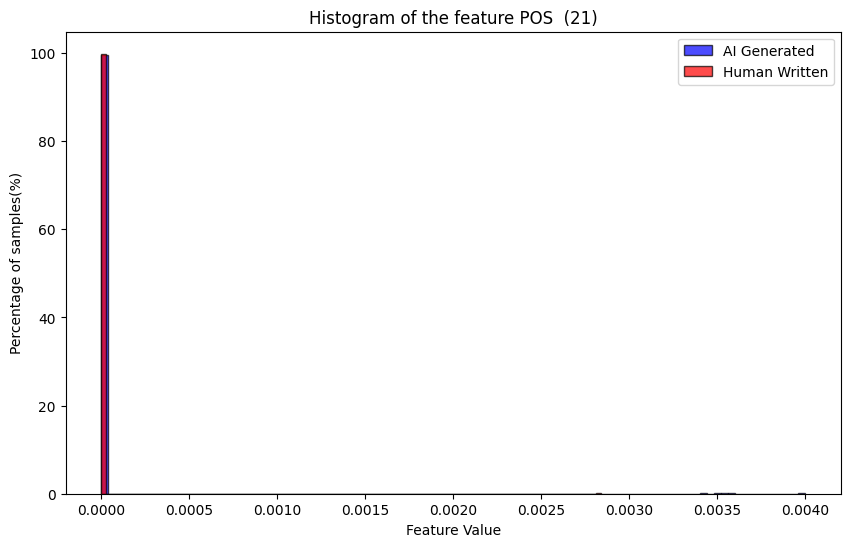

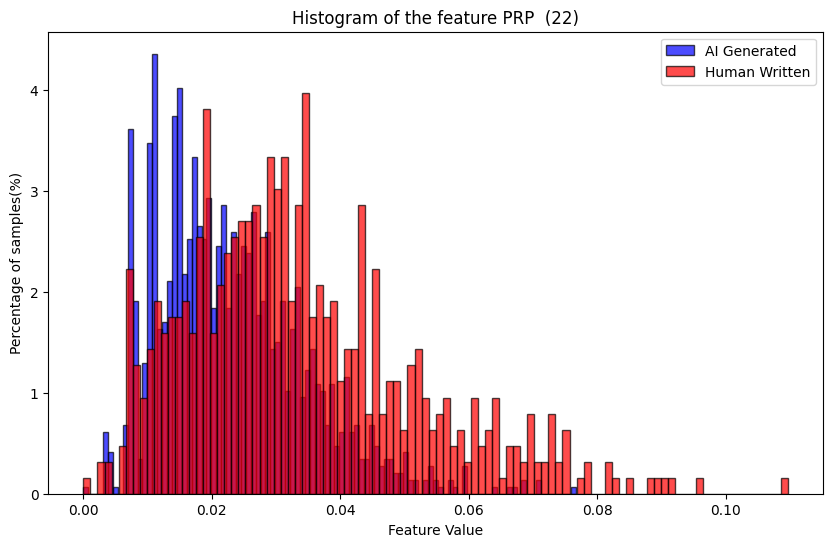

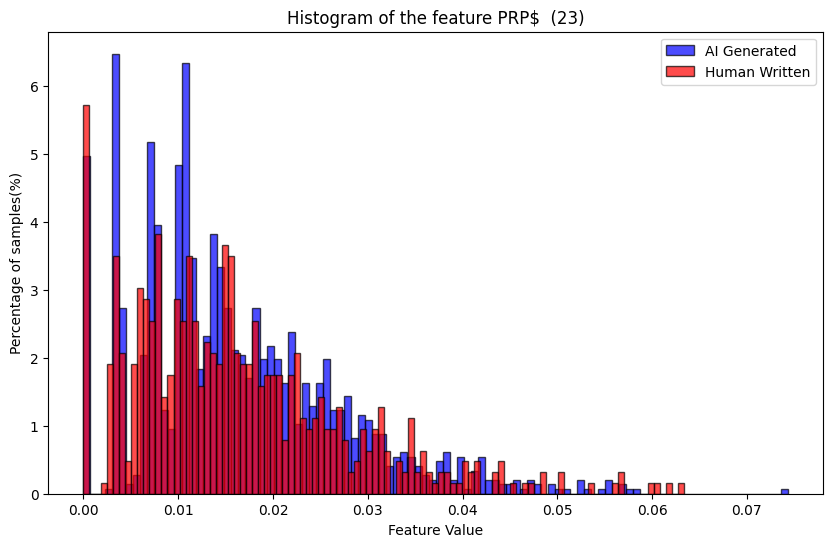

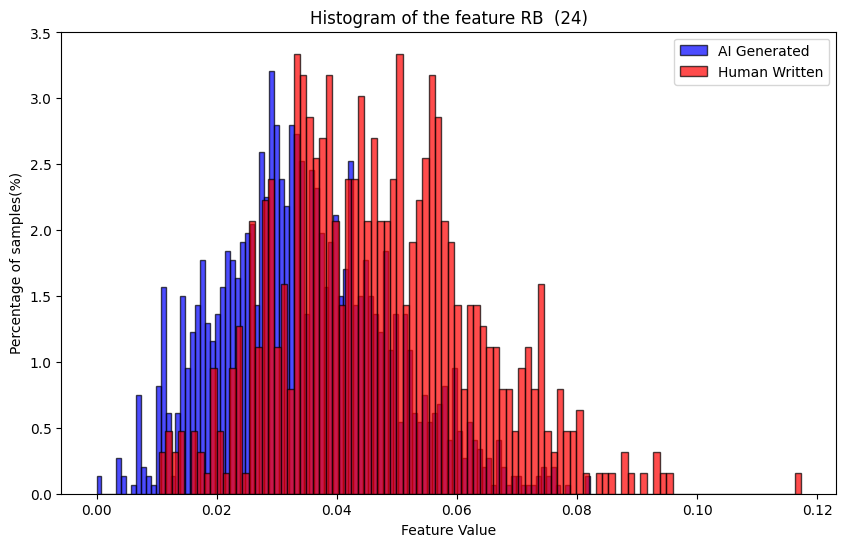

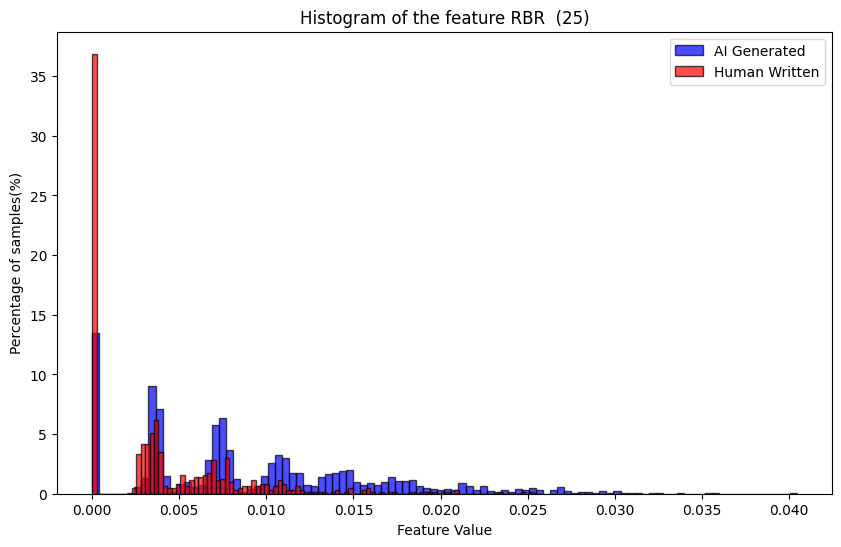

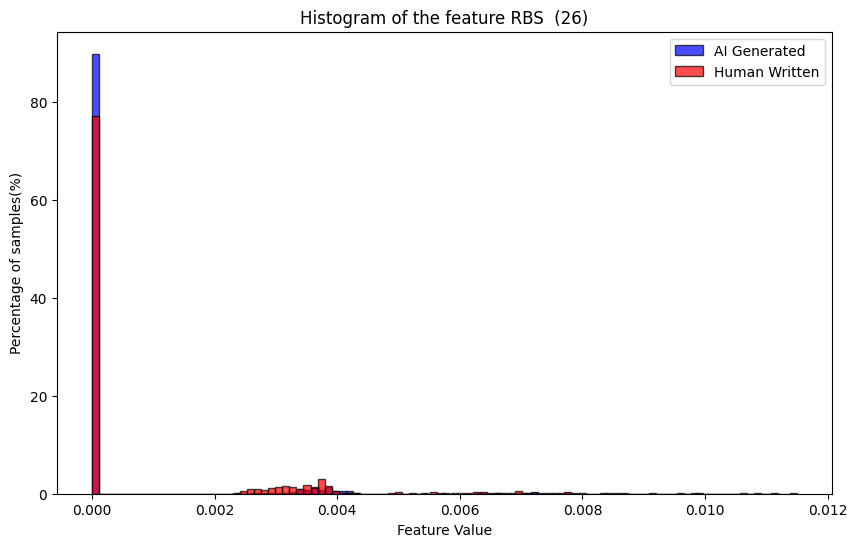

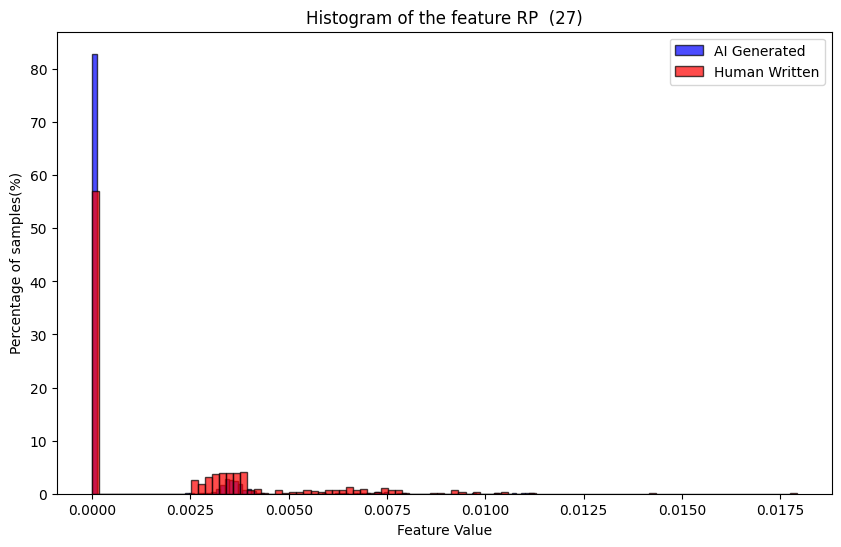

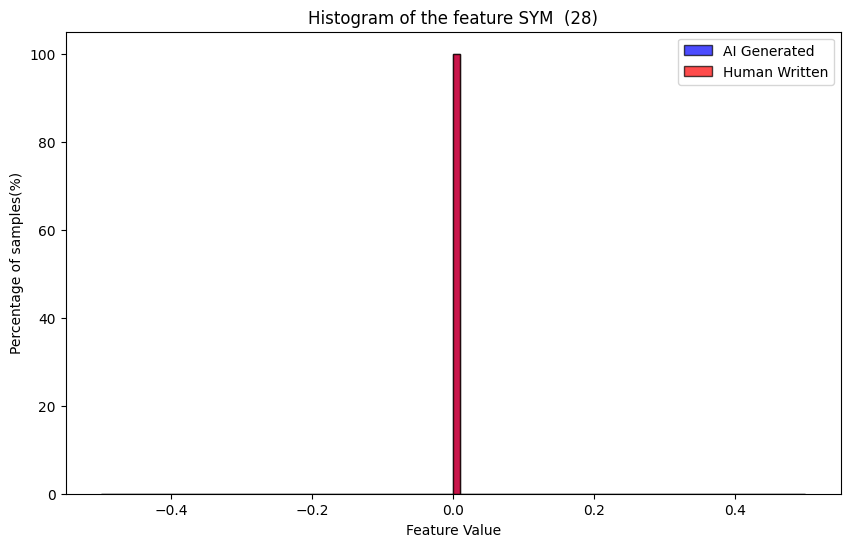

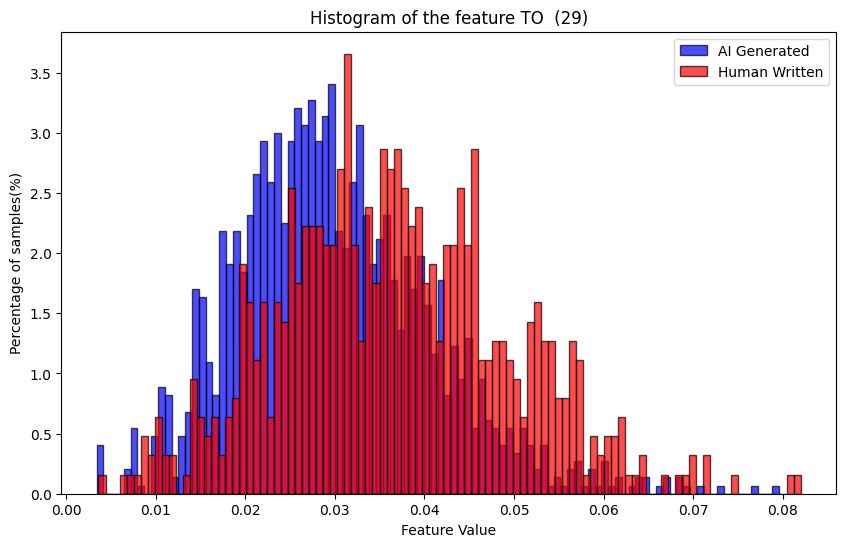

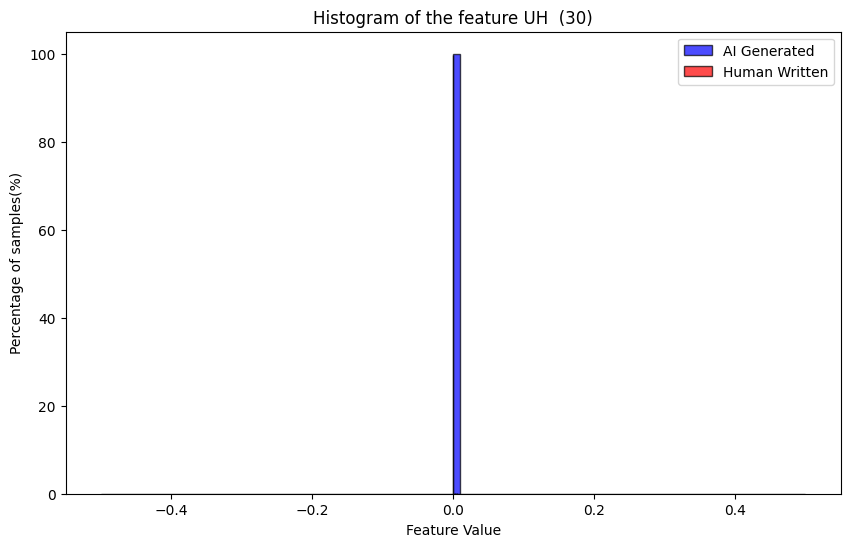

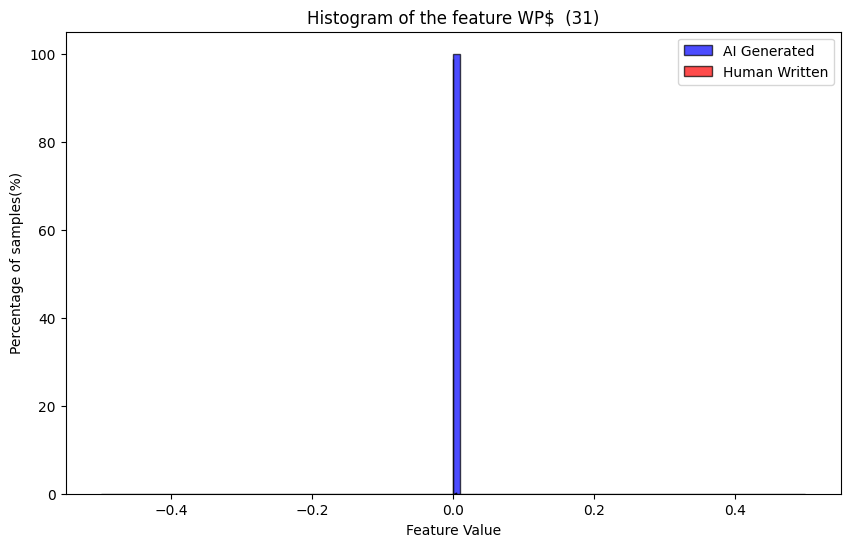

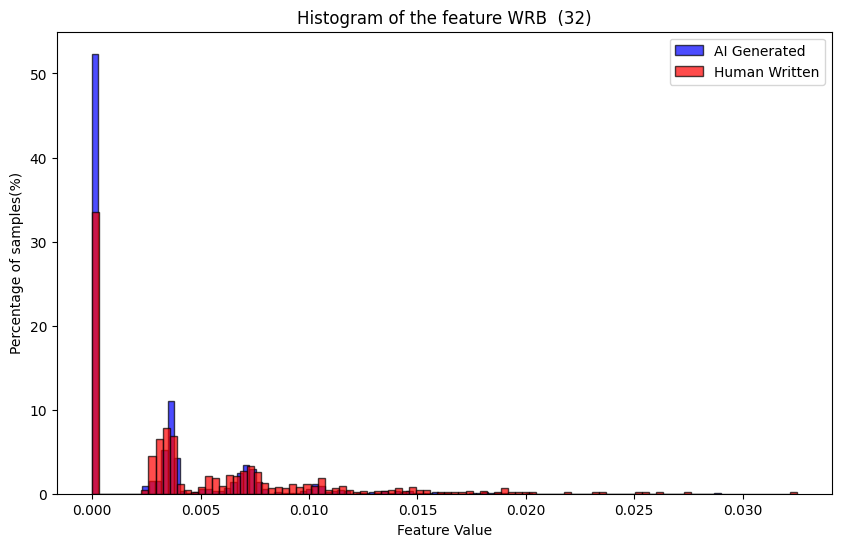

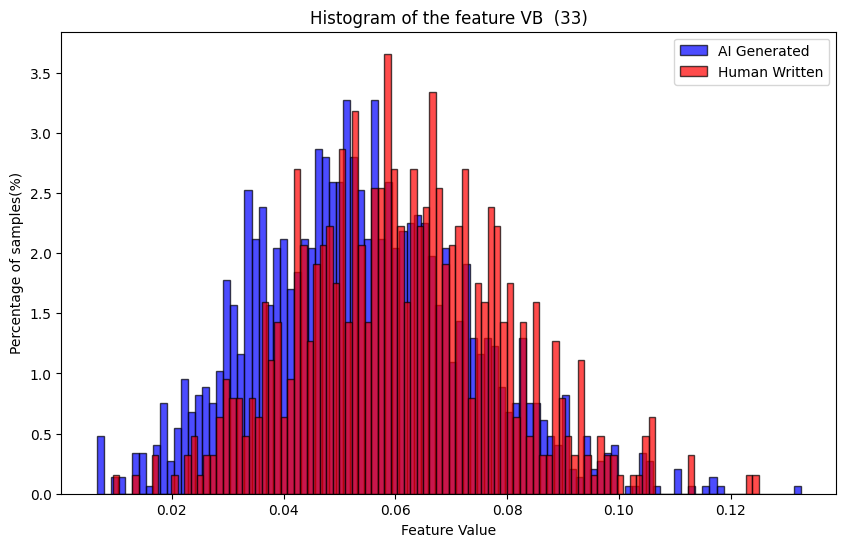

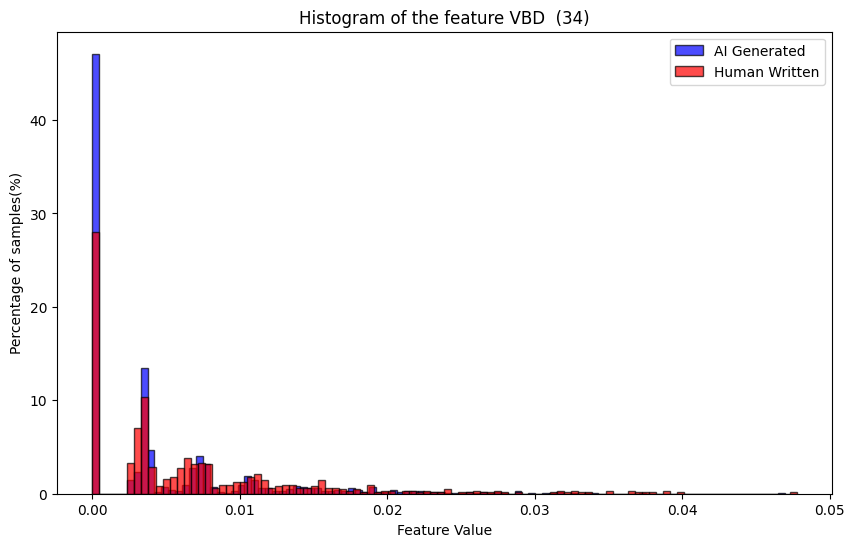

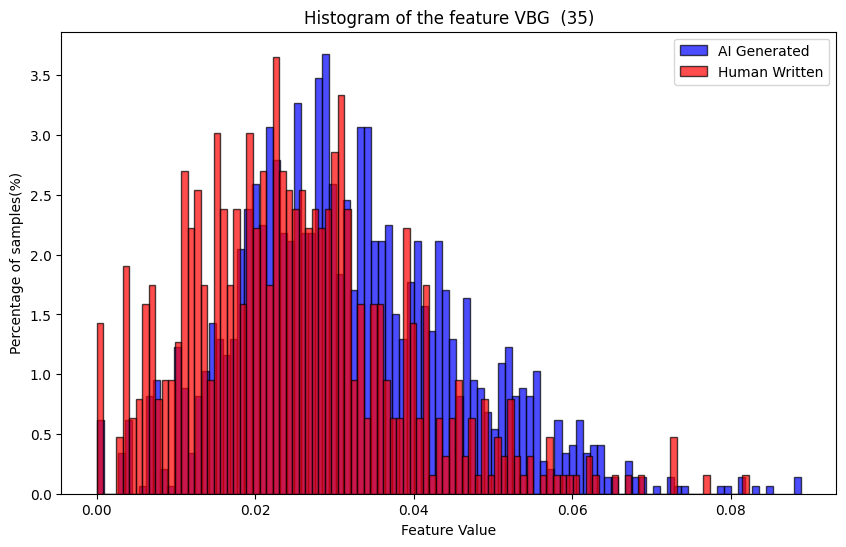

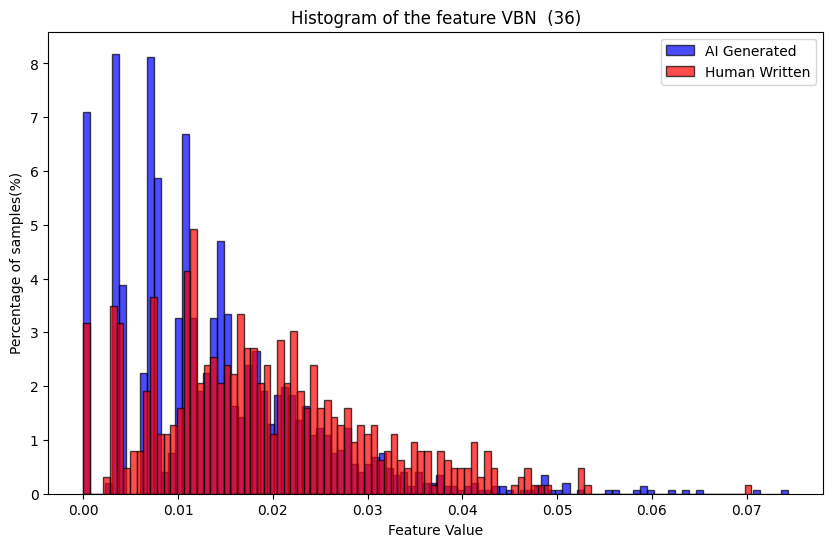

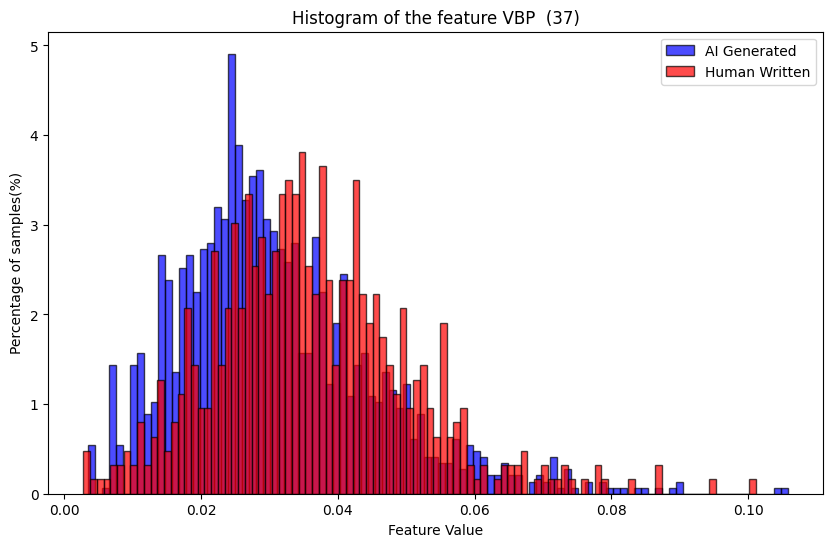

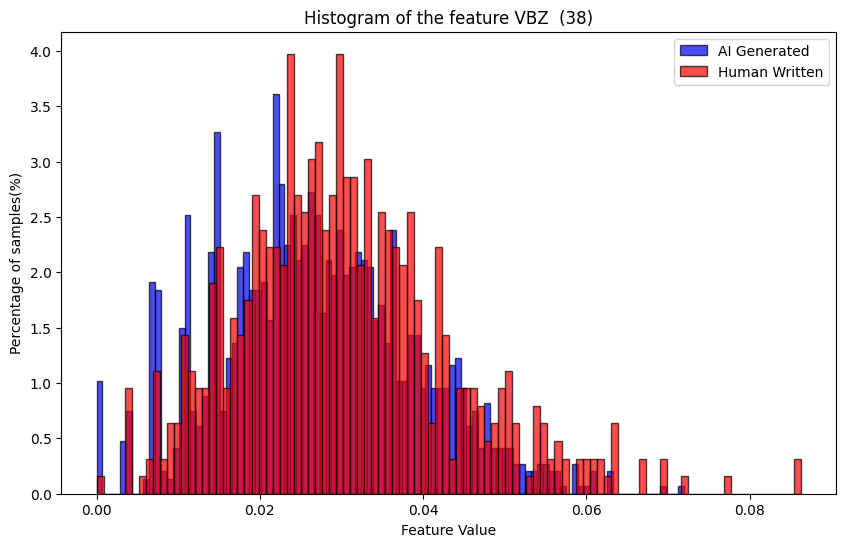

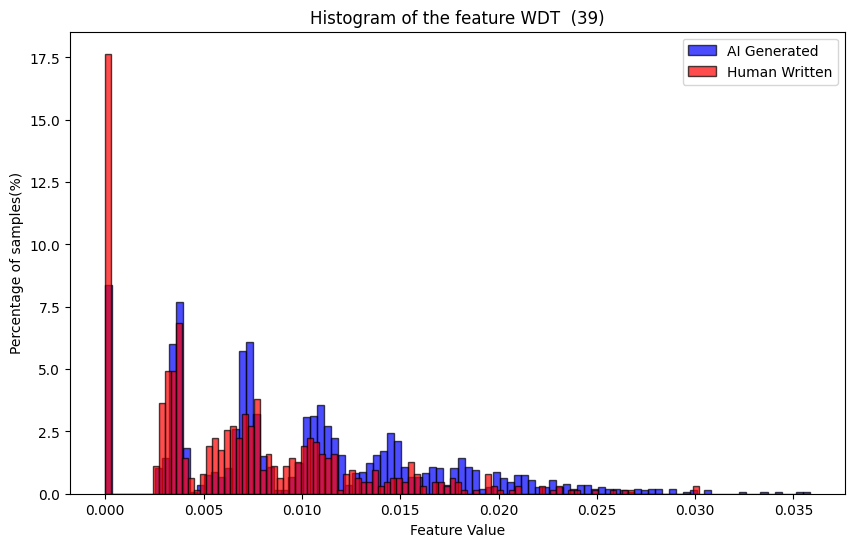

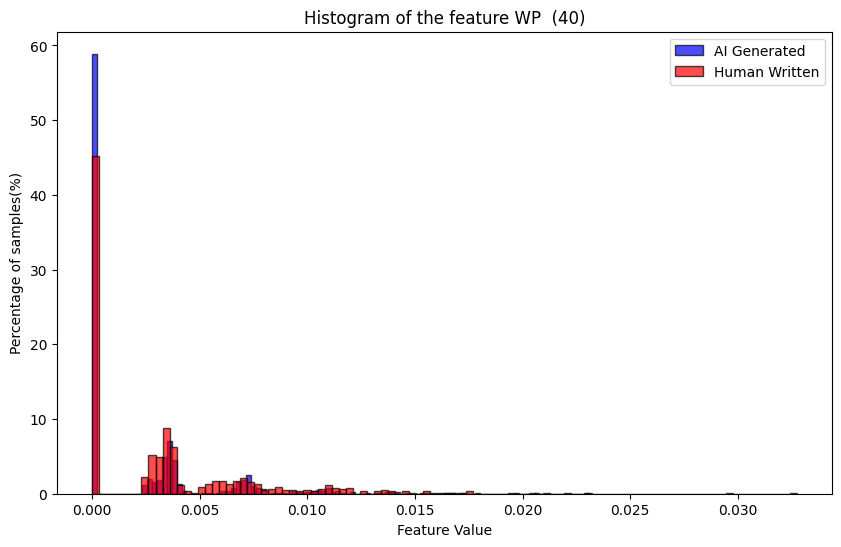

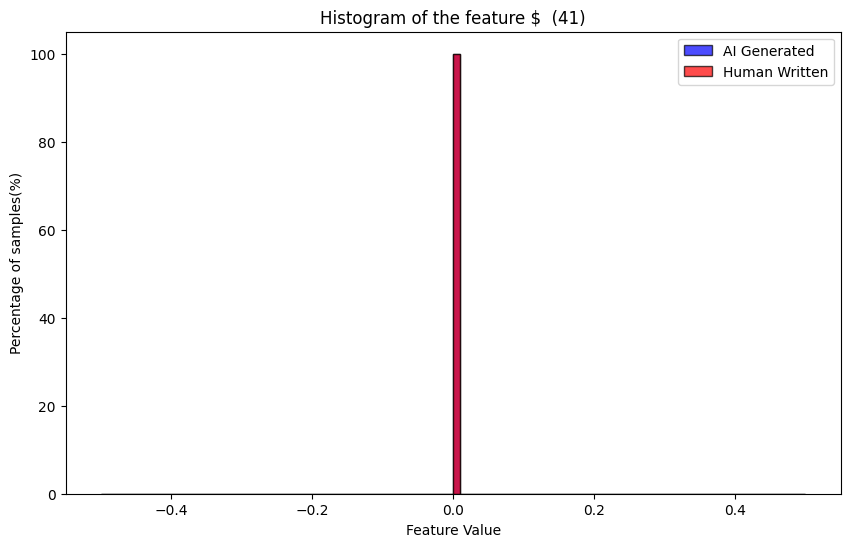

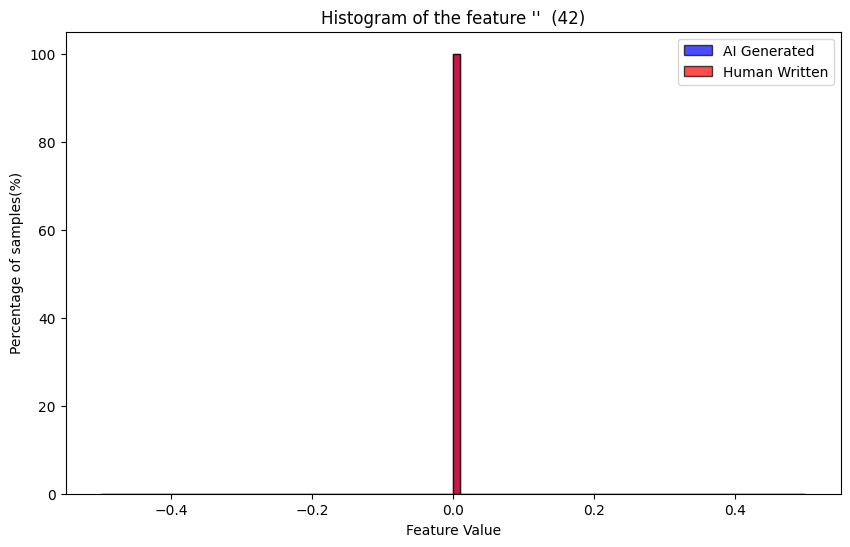

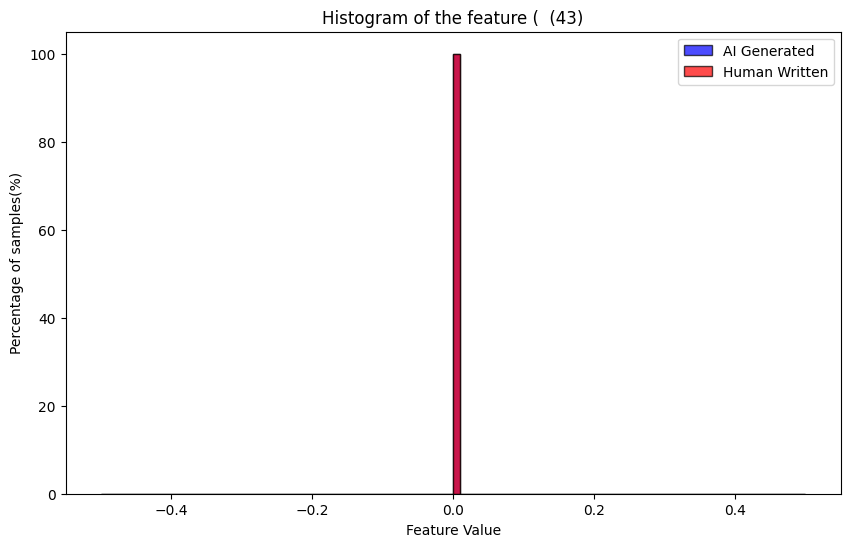

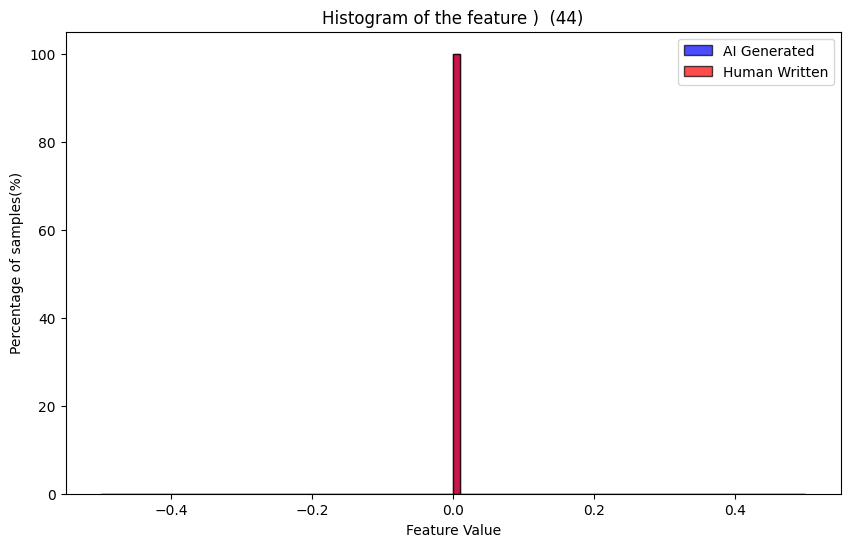

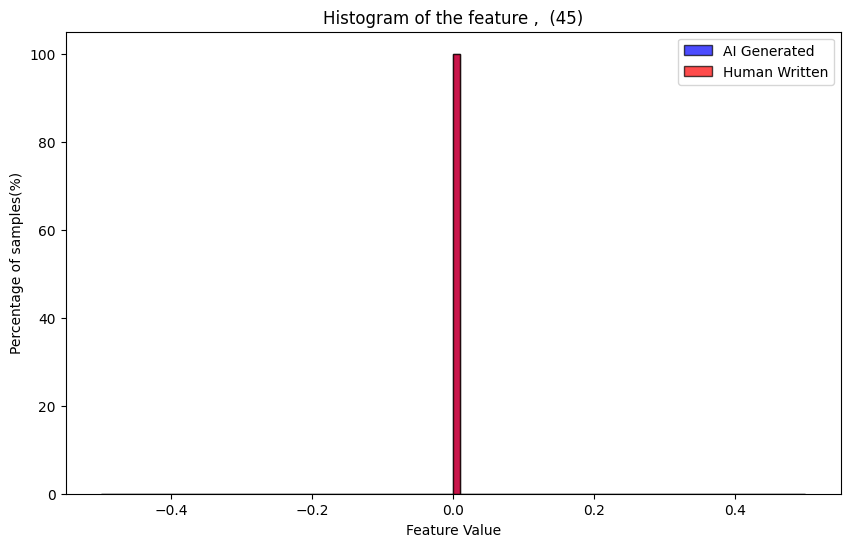

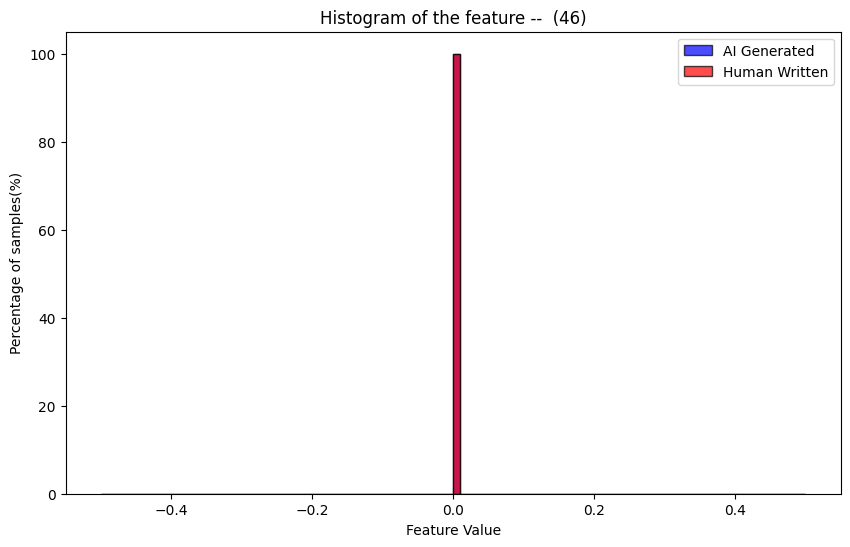

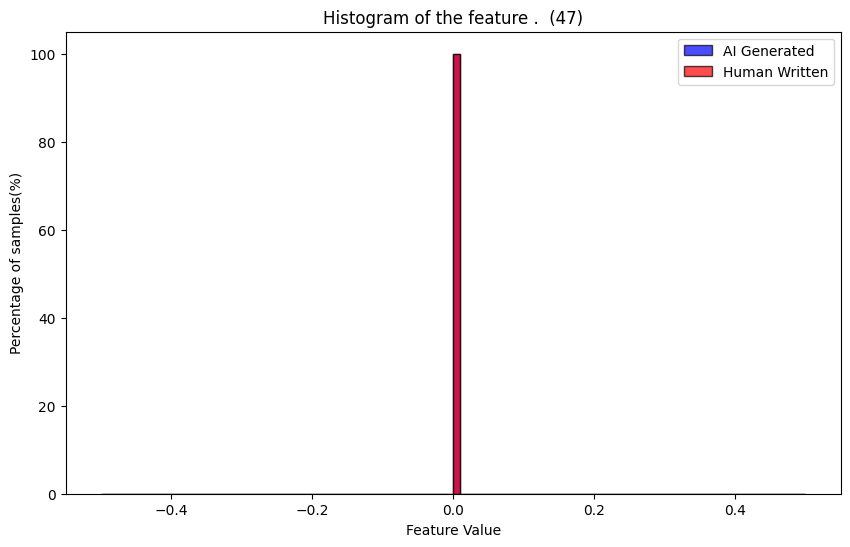

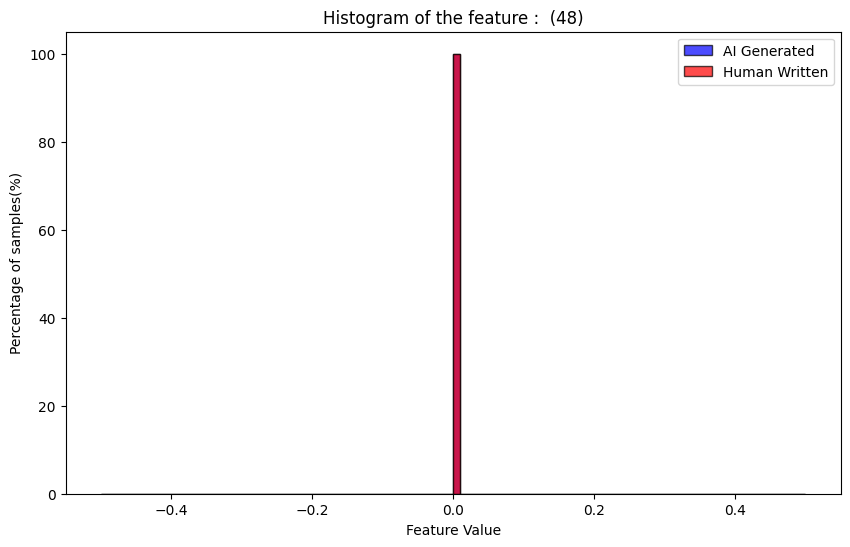

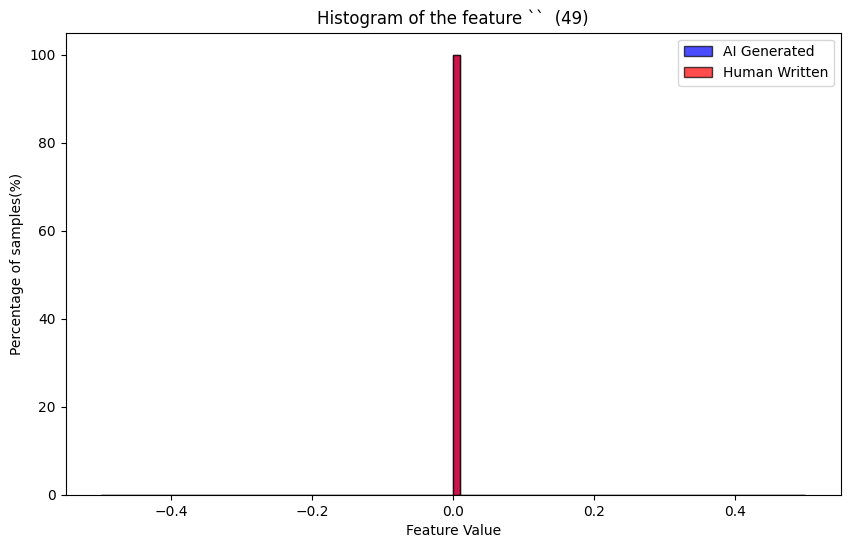

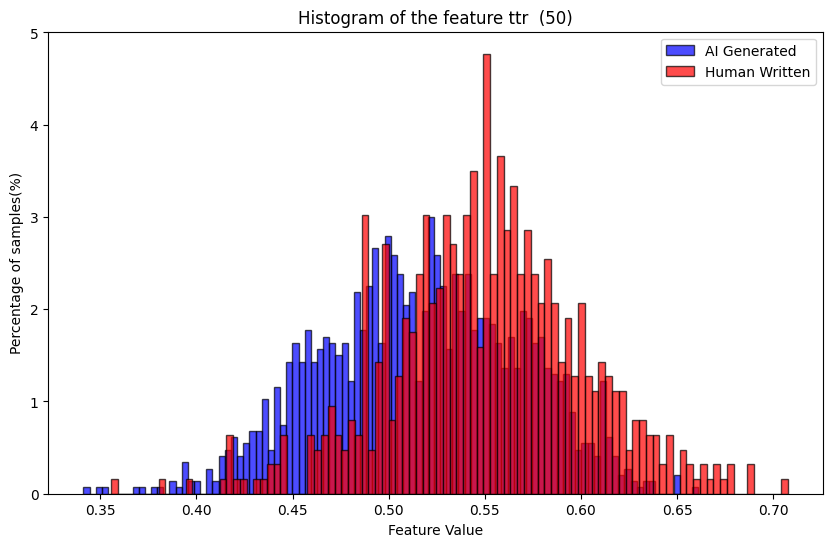

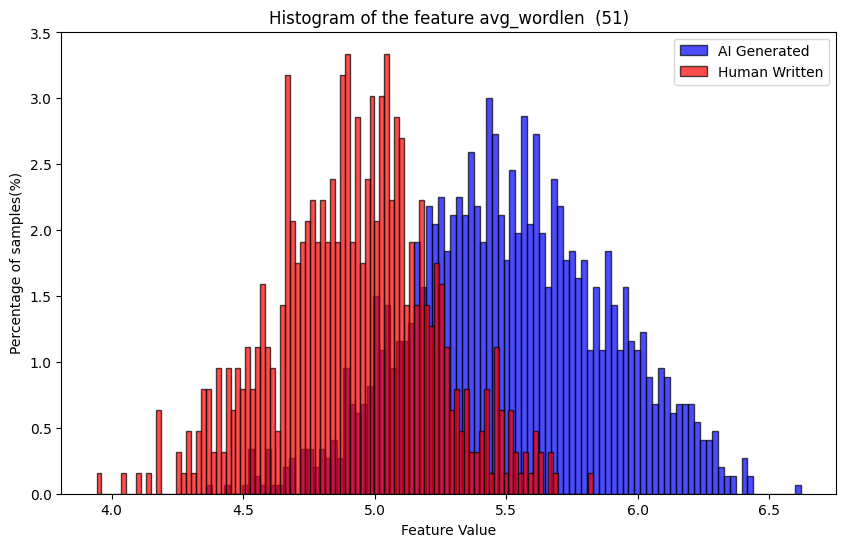

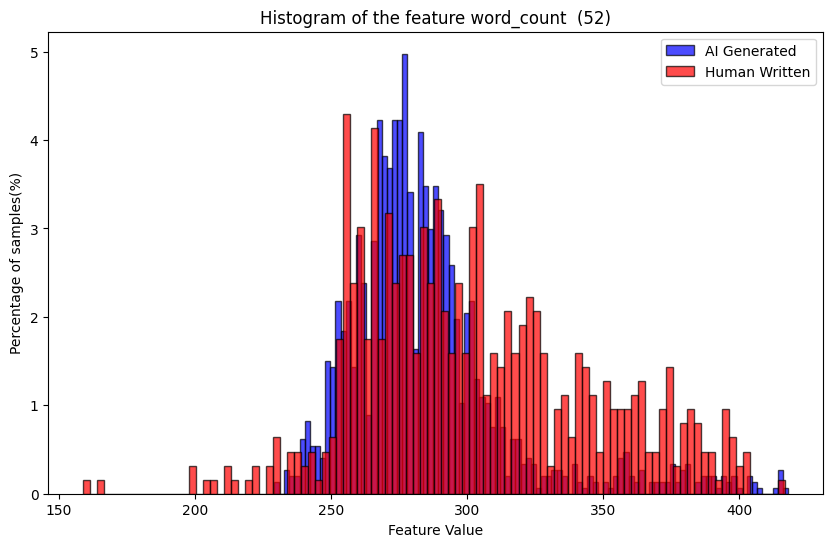

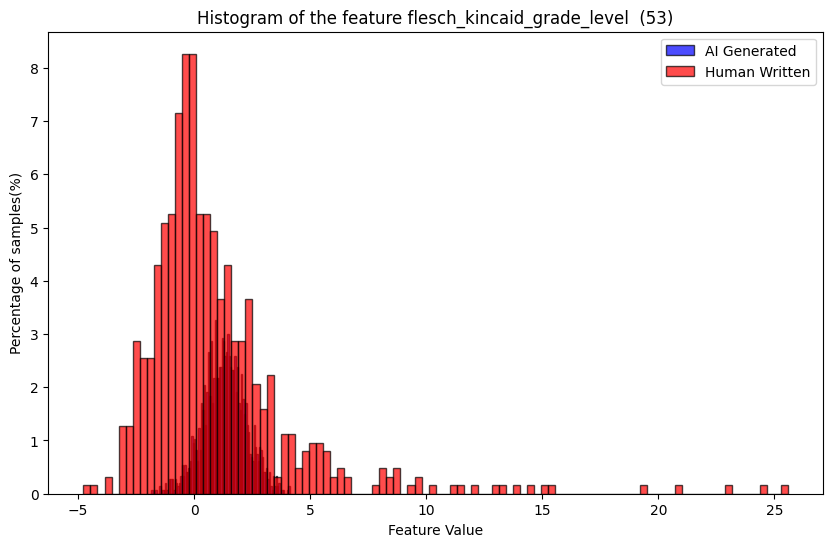

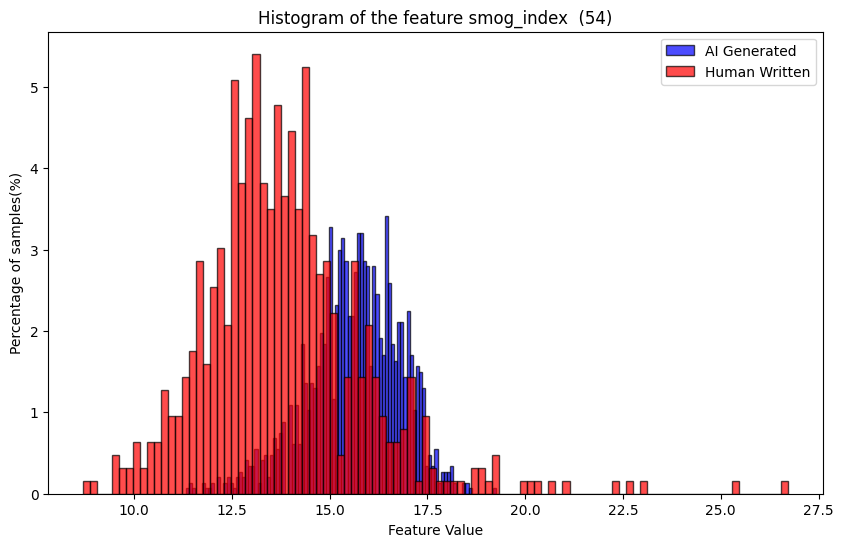

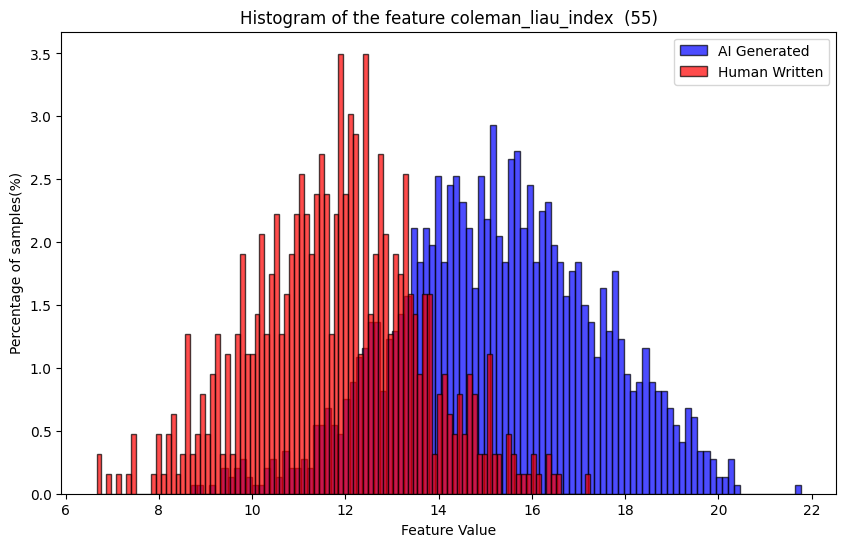

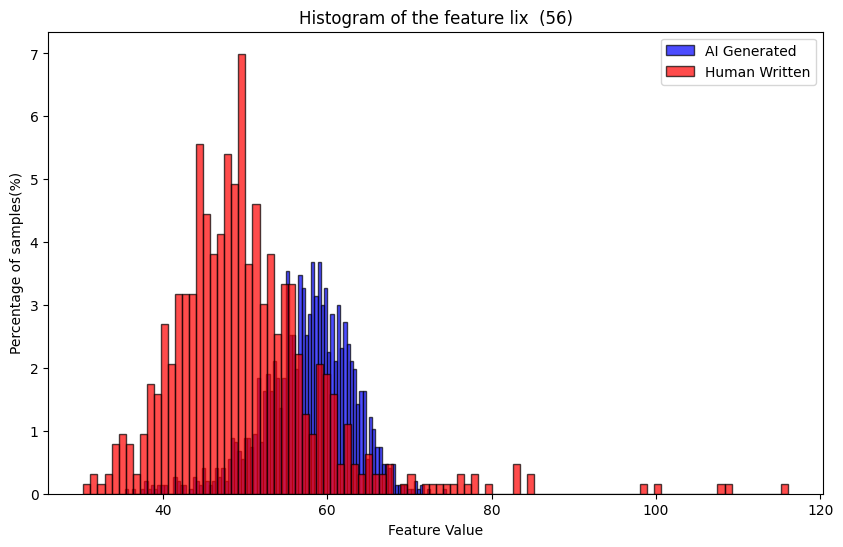

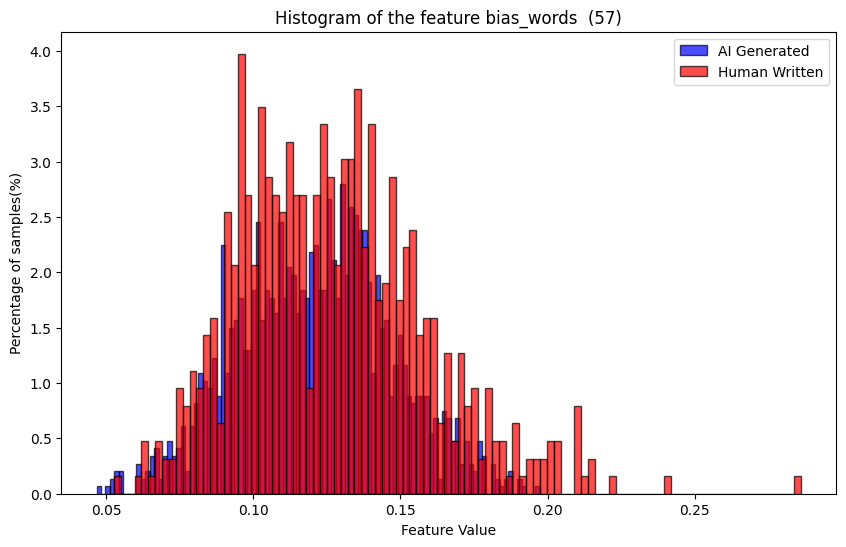

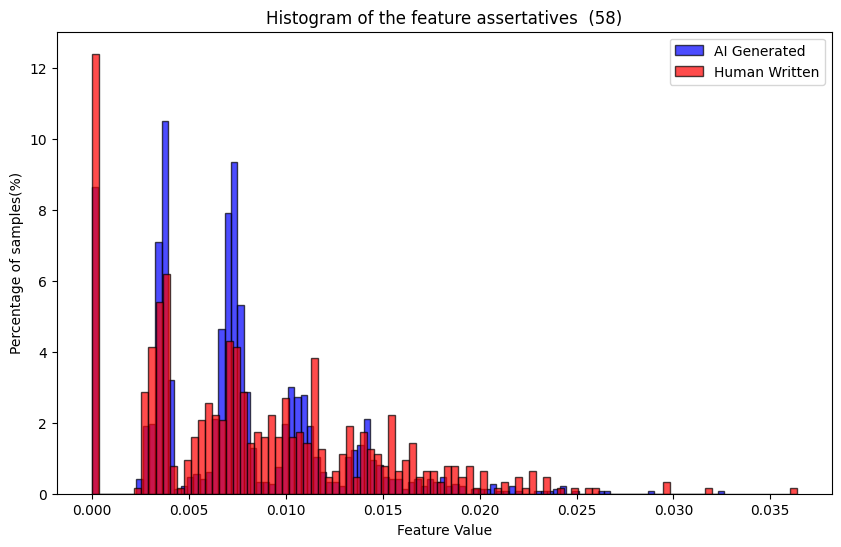

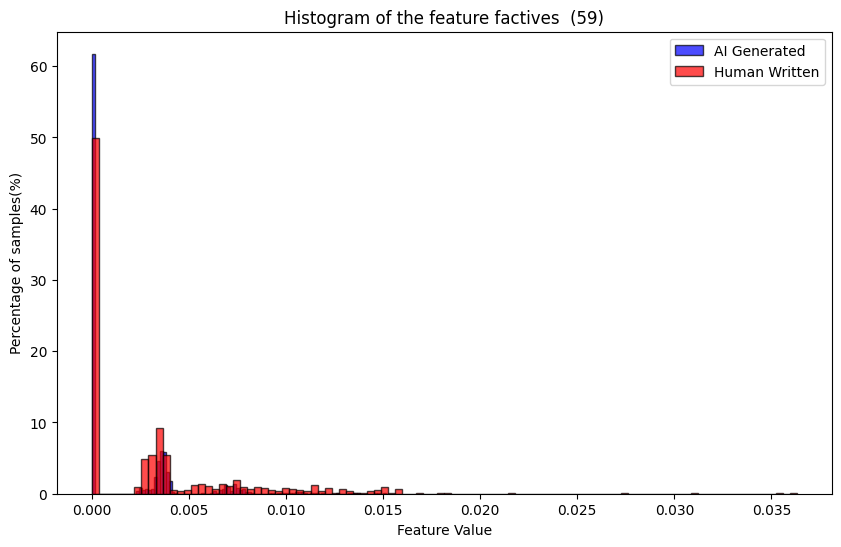

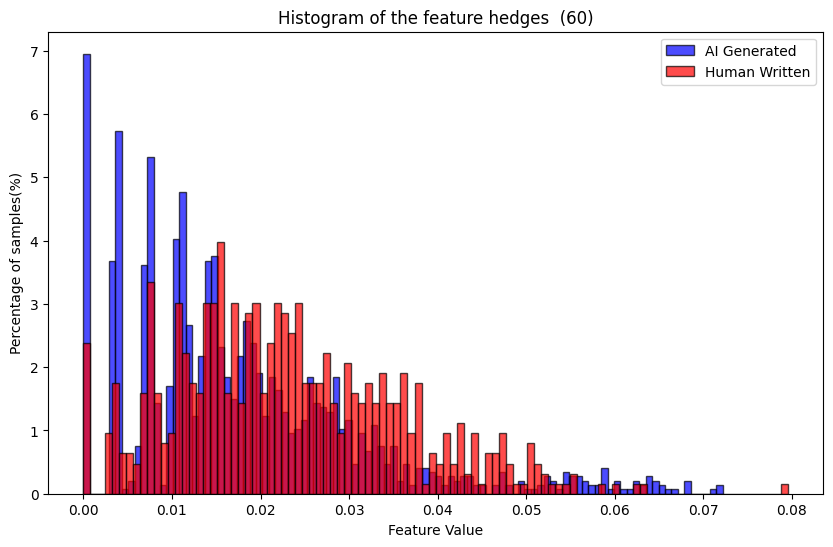

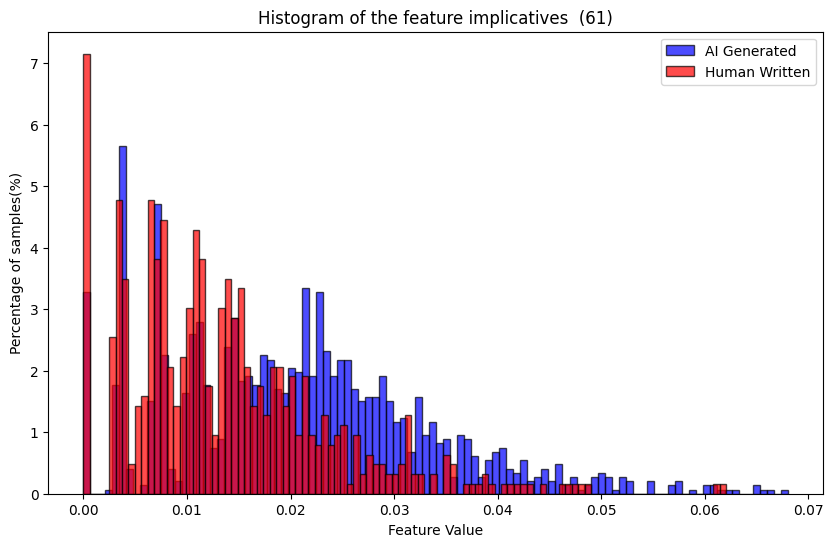

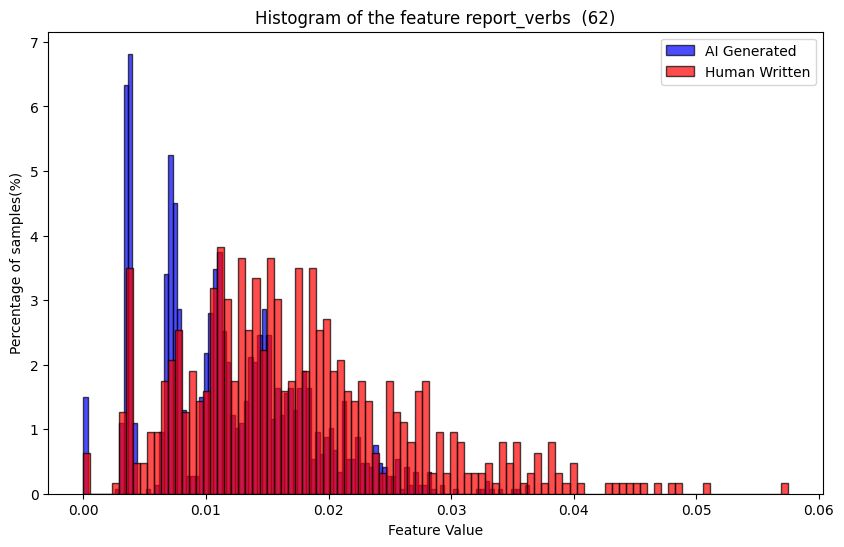

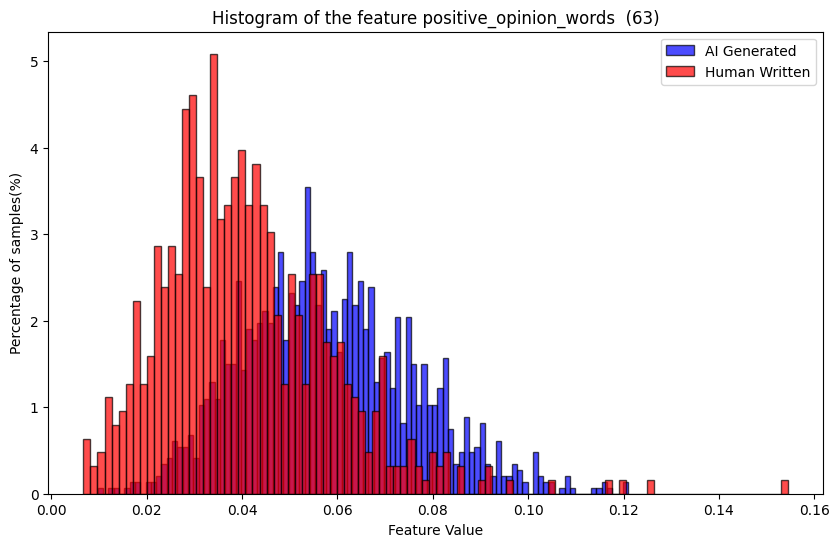

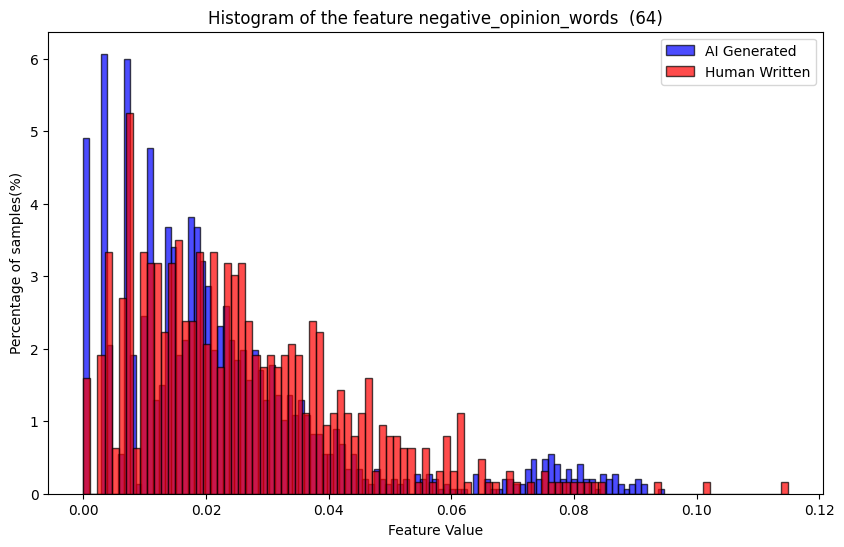

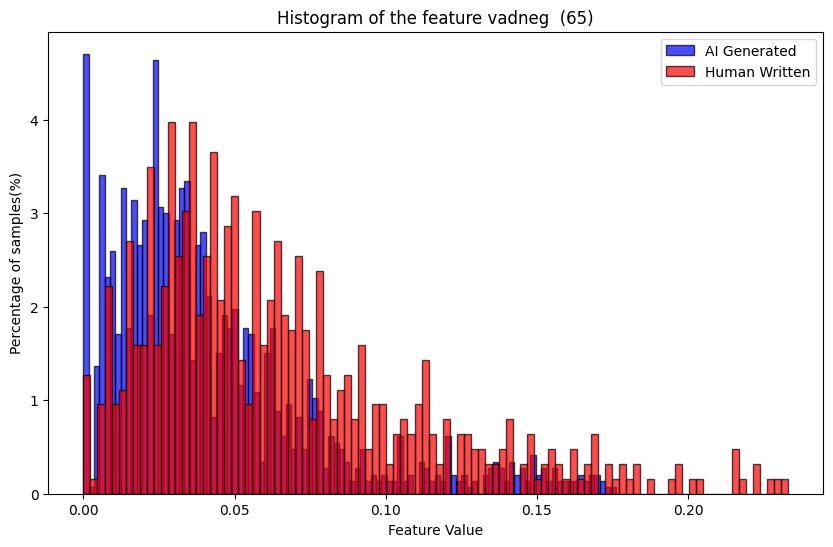

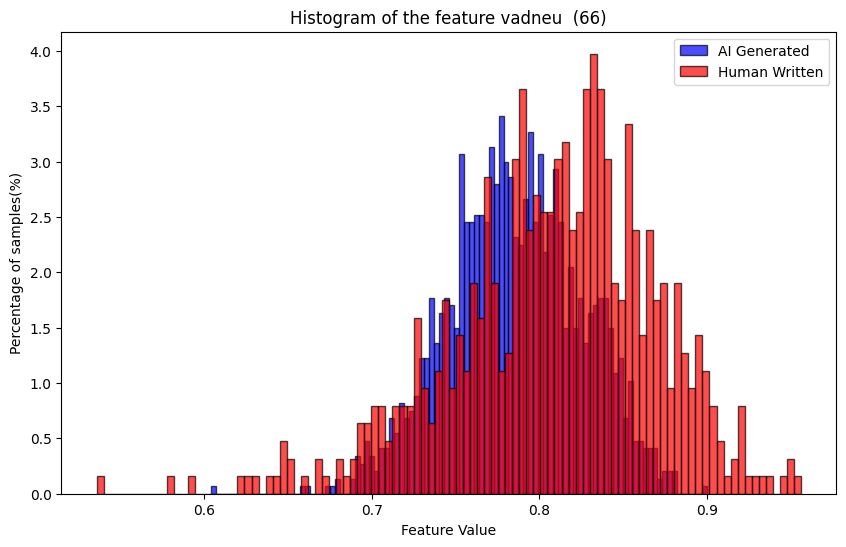

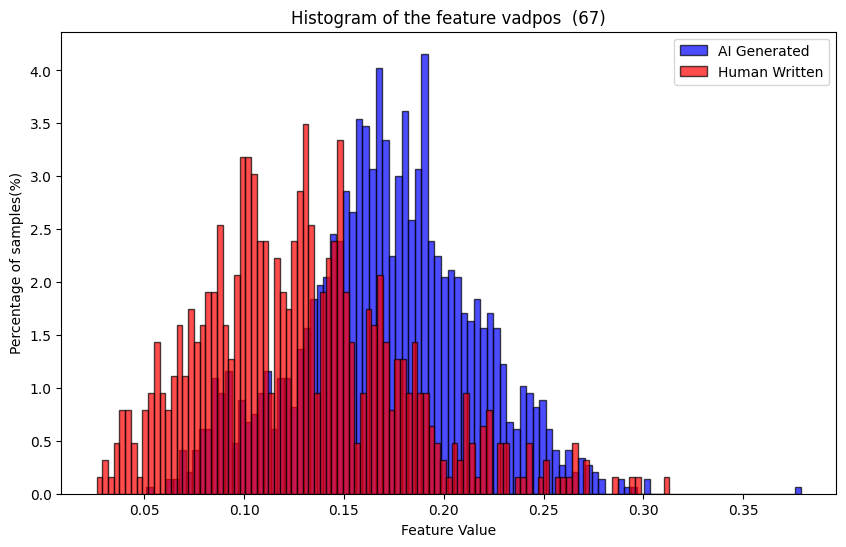

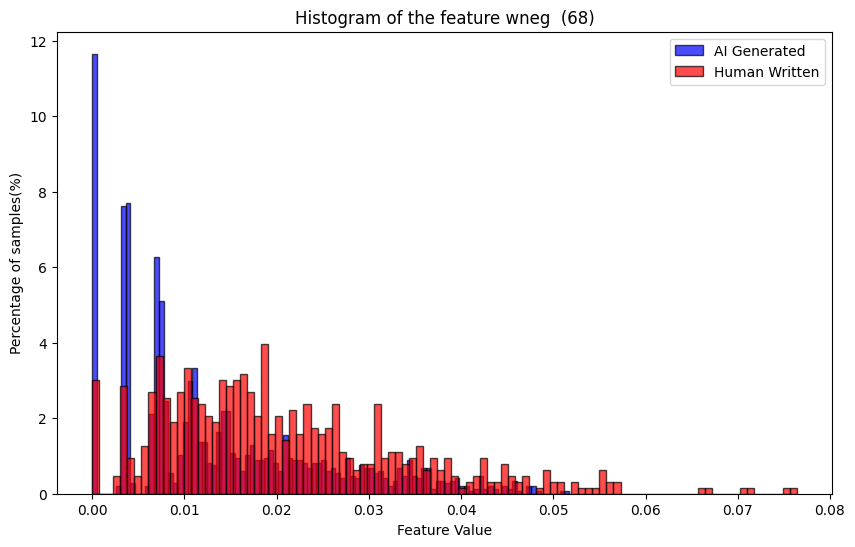

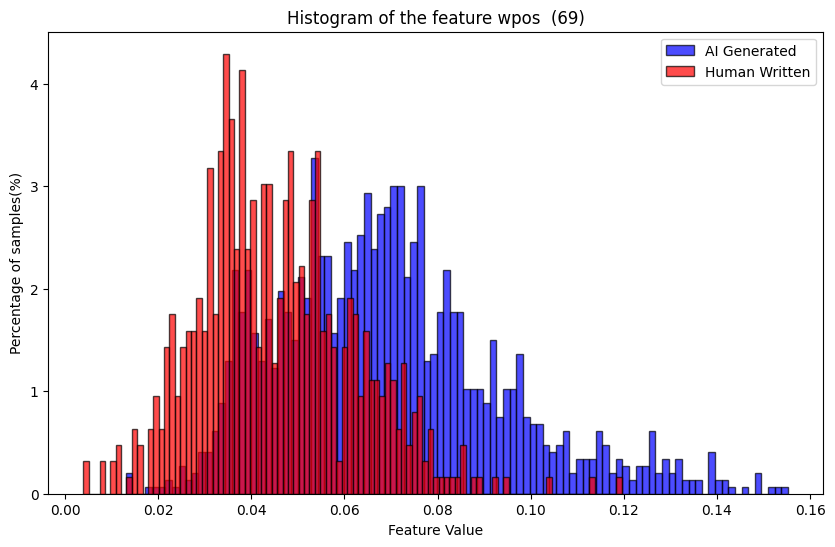

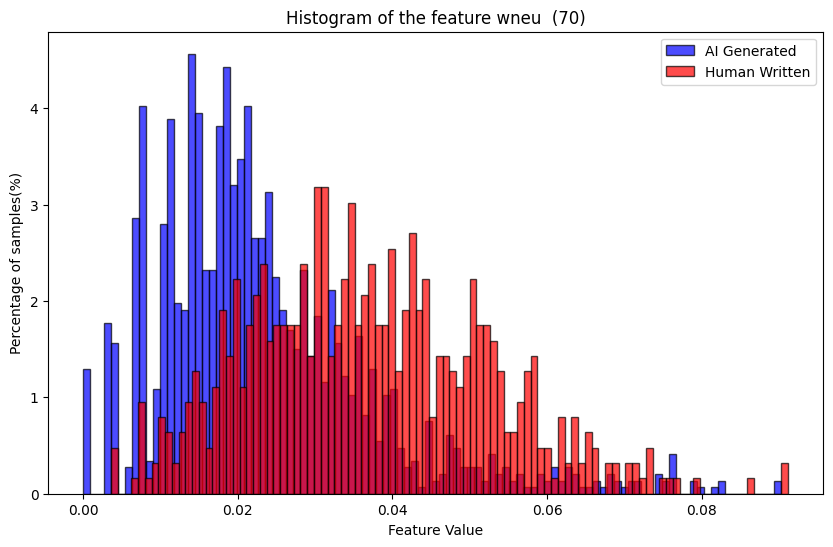

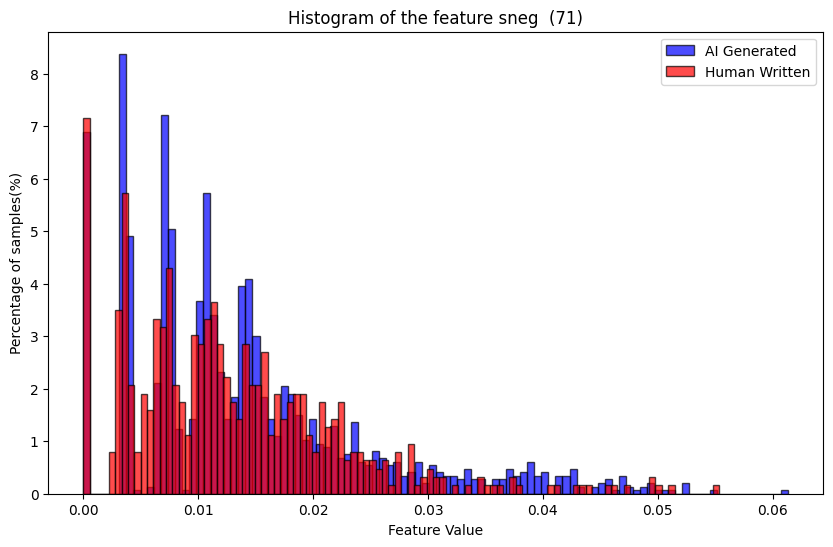

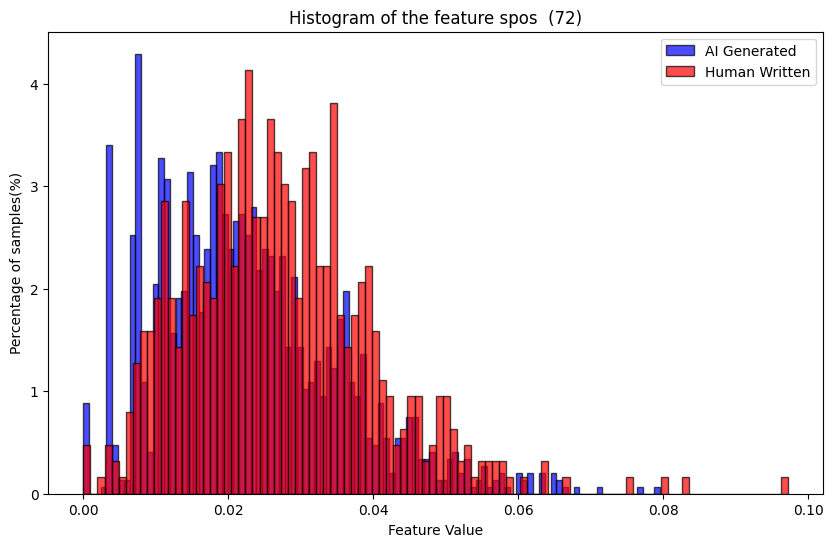

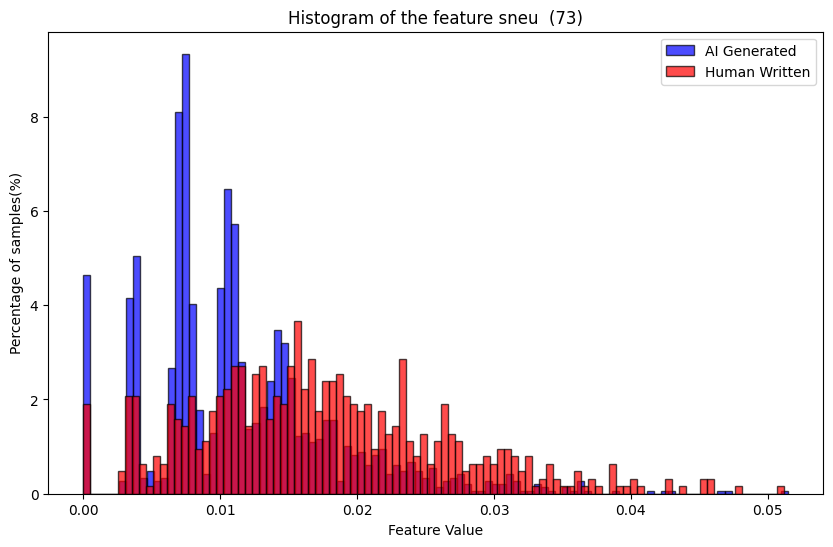

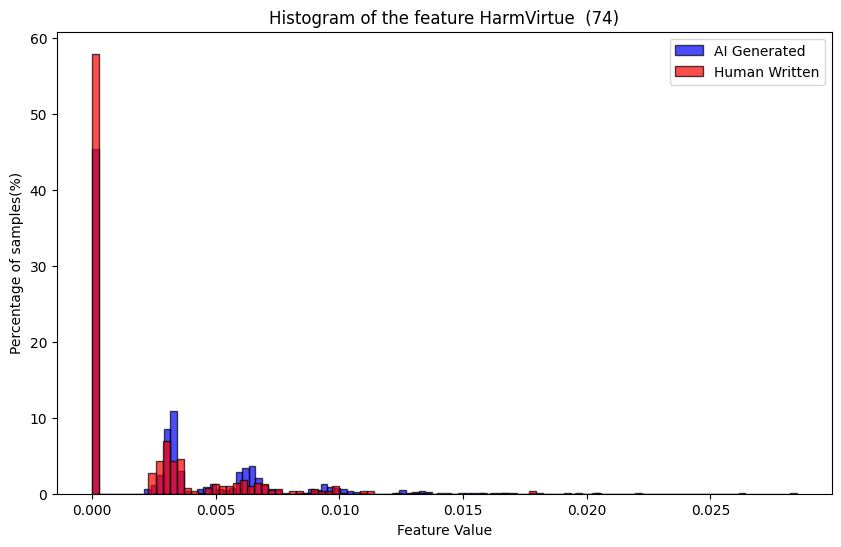

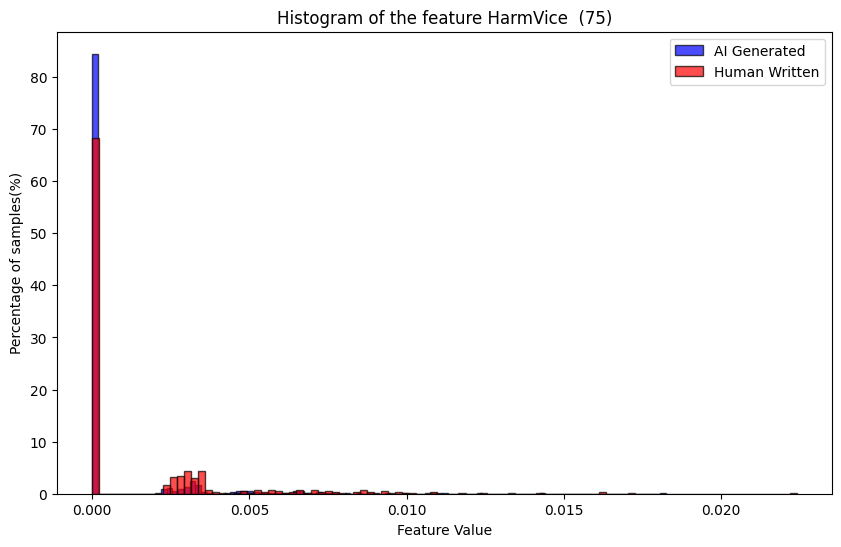

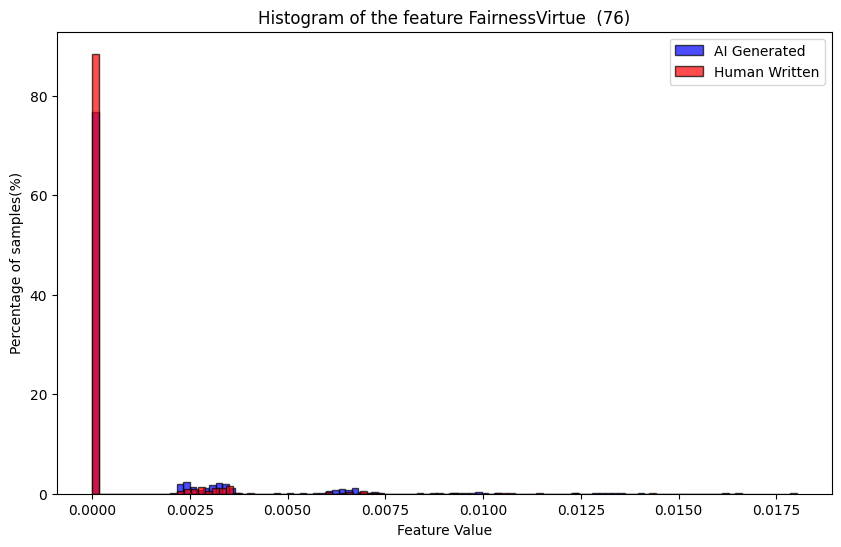

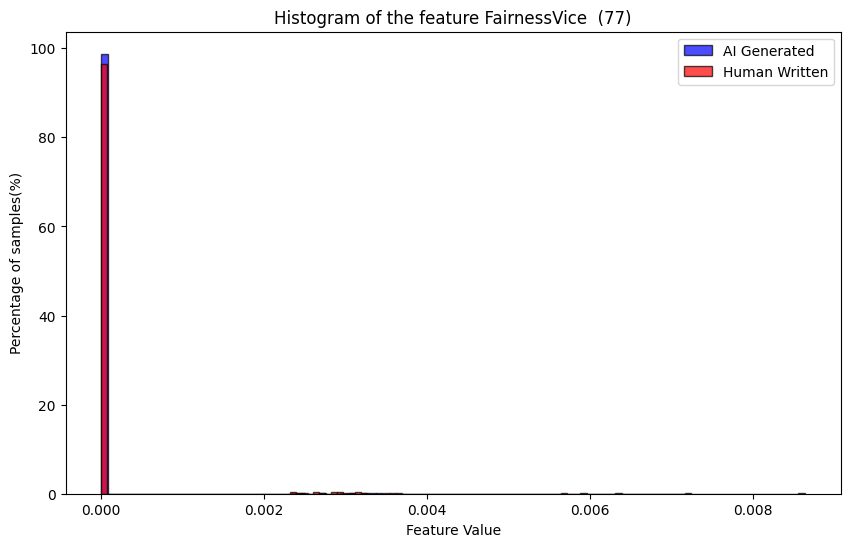

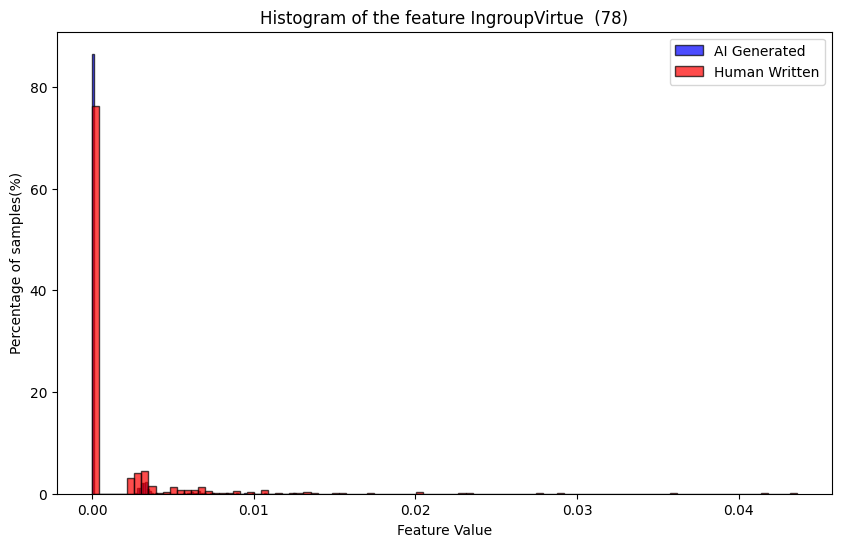

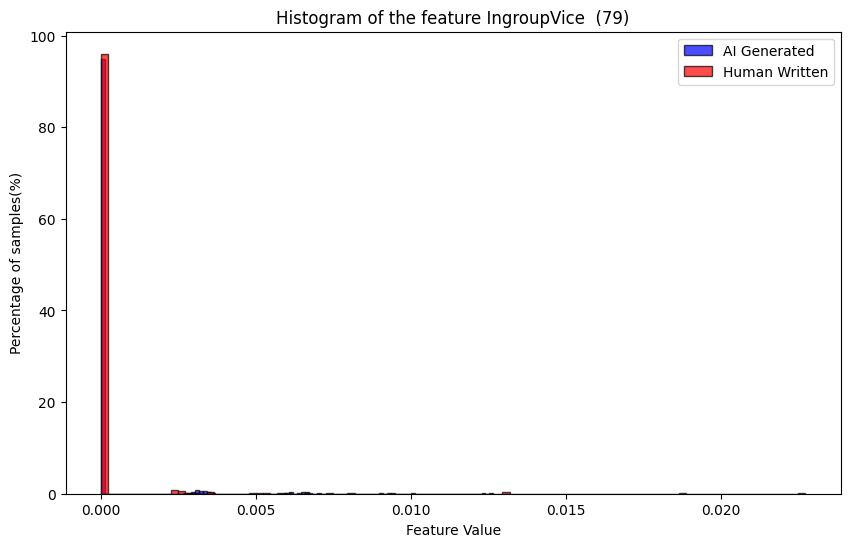

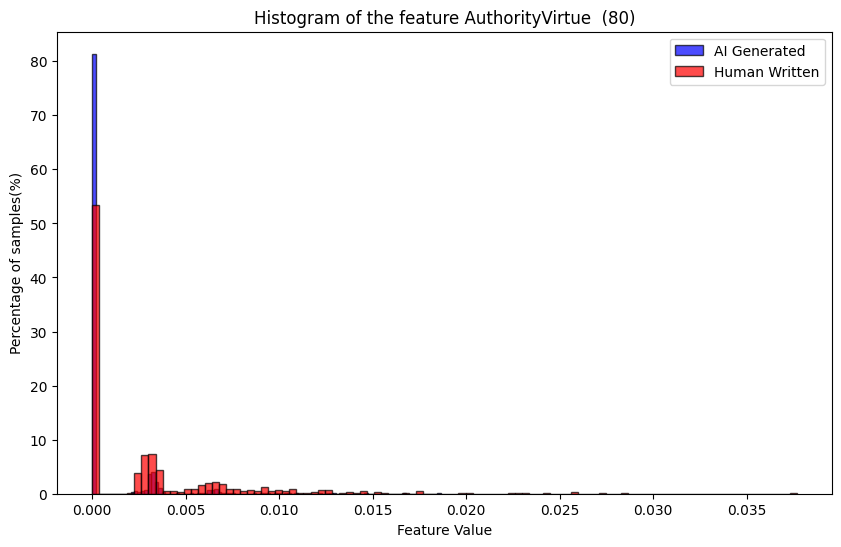

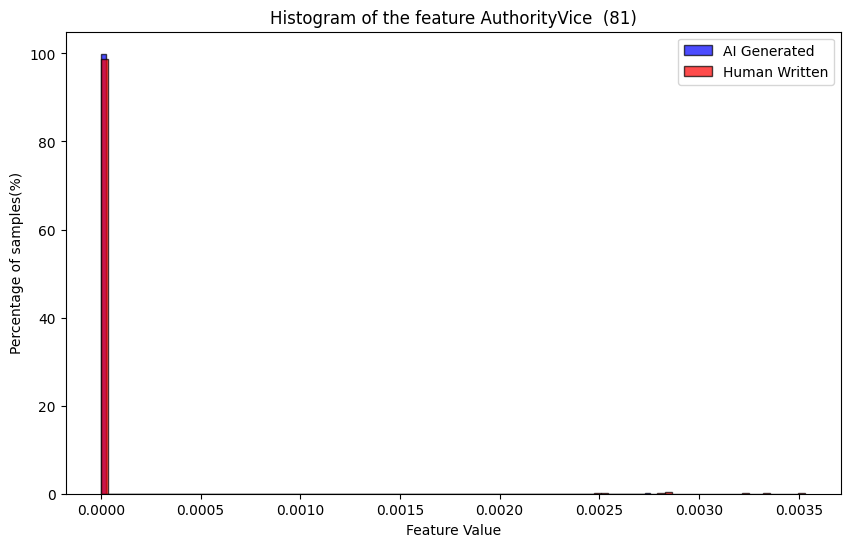

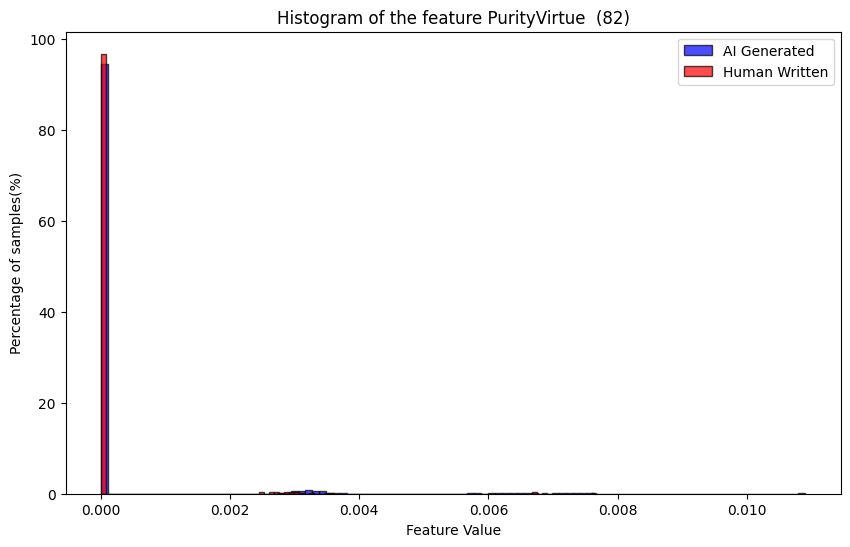

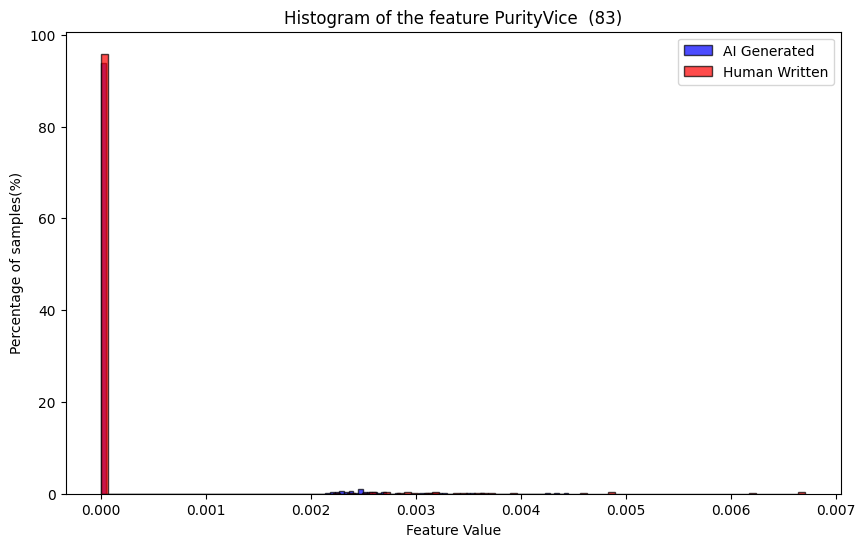

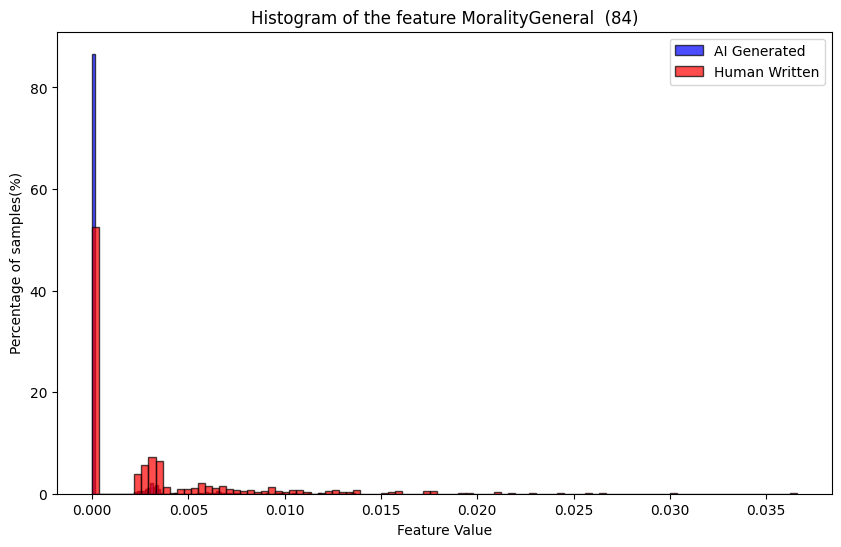

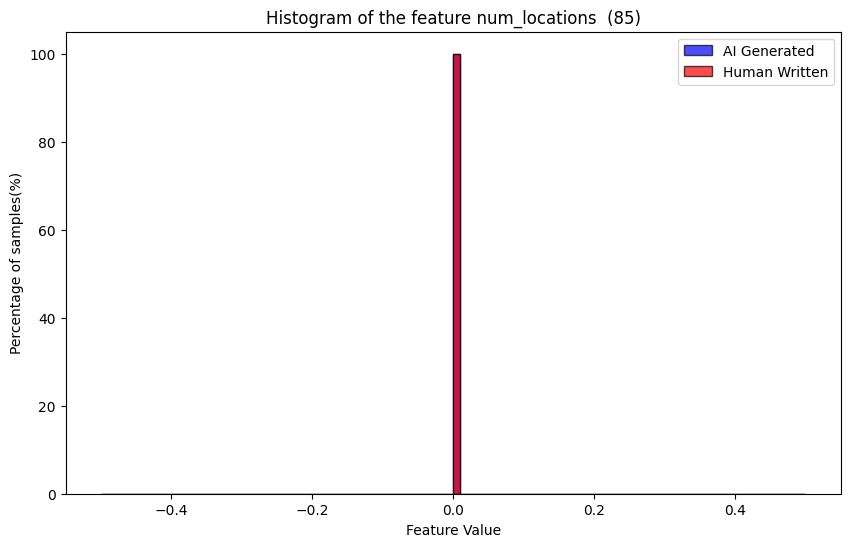

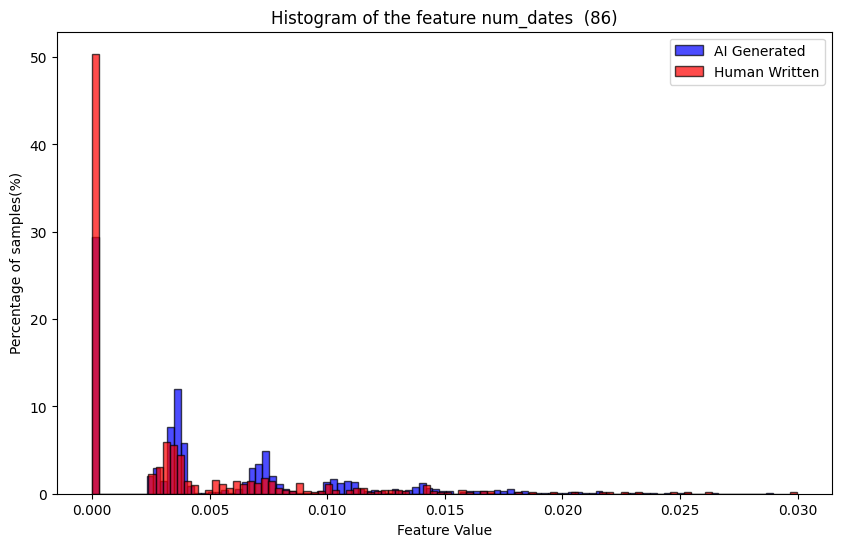

In [ ]:
for i, feature_name in enumerate(all_feature_names):
  plot_feature_graph(i, feature_name, X_train, train_labels)

In [ ]:
# Try the readability features
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.3 MB/s eta 0:00:00


In [ ]:
import textstat
def get_readability_features(test_data):
  return [textstat.flesch_reading_ease(test_data),
textstat.flesch_kincaid_grade(test_data),
textstat.smog_index(test_data),
textstat.coleman_liau_index(test_data),
textstat.automated_readability_index(test_data),
textstat.dale_chall_readability_score(test_data),
textstat.difficult_words(test_data),
textstat.linsear_write_formula(test_data),
textstat.gunning_fog(test_data),
#textstat.text_standard(test_data),
textstat.fernandez_huerta(test_data),
textstat.szigriszt_pazos(test_data),
textstat.gutierrez_polini(test_data),
textstat.crawford(test_data),
textstat.gulpease_index(test_data),
textstat.osman(test_data)]

In [ ]:
print(get_readability_features(train_texts[0]) )

[54.46, 11.9, 13.6, 11.09, 14.3, 8.71, 13.6, 91.24, 86.54, 39.47, 3.3, 51.6, 50.25]


In [ ]:
X_read_train = [get_readability_features(X) for X in tqdm(train_texts)]
X_read_val = [get_readability_features(X) for X in tqdm(val_texts)]

100%|██████████| 1626/1626 [00:21<00:00, 75.80it/s]


In [ ]:
# Save the X_read_train and X_read_val as pickle files
import pickle
with open('X_read_train.pkl', 'wb') as f:
    pickle.dump(X_read_train, f)
with open('X_read_val.pkl', 'wb') as f:
    pickle.dump(X_read_val, f)

In [ ]:
# Train the model using random forest
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
print("Fitting RF classifier...")
classifier.fit(X_read_train, train_labels)
score = classifier.score(X_read_val, val_labels)
print('Random Forest Score:', score)
predictions = classifier.predict(X_read_val)
print('Random Forest Accuracy:', accuracy_score(val_labels, predictions))
print('Random Forest Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting RF classifier...
Random Forest Score: 0.9692496924969249
Random Forest Accuracy: 0.9692496924969249
Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.9684    0.9919    0.9800      1235
           1     0.9723    0.8977    0.9335       391

    accuracy                         0.9692      1626
   macro avg     0.9703    0.9448    0.9568      1626
weighted avg     0.9693    0.9692    0.9688      1626



In [ ]:
classifier = LogisticRegression()
print("Fitting LR classifier...")
classifier.fit(X_read_train, train_labels)
score = classifier.score(X_read_val, val_labels)
print('Logistic Regression Score:', score)
predictions = classifier.predict(X_read_val)
print('Logistic Regression Accuracy:', accuracy_score(val_labels, predictions))
print('Logistic Regression Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting LR classifier...
Logistic Regression Score: 0.9710947109471094
Logistic Regression Accuracy: 0.9710947109471094
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     0.9707    0.9919    0.9812      1235
           1     0.9725    0.9054    0.9377       391

    accuracy                         0.9711      1626
   macro avg     0.9716    0.9486    0.9595      1626
weighted avg     0.9711    0.9711    0.9707      1626



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Fit an extratree classifier
from sklearn.ensemble import ExtraTreesClassifier
classifier = ExtraTreesClassifier()
print("Fitting ET classifier...")
classifier.fit(X_read_train, train_labels)
score = classifier.score(X_read_val, val_labels)
print('Extra Trees Score:', score)
predictions = classifier.predict(X_read_val)
print('Extra Trees Accuracy:', accuracy_score(val_labels, predictions))
print('Extra Trees Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting ET classifier...
Extra Trees Score: 0.9674046740467405
Extra Trees Accuracy: 0.9674046740467405
Extra Trees Classification Report:
              precision    recall  f1-score   support

           0     0.9690    0.9887    0.9788      1235
           1     0.9617    0.9003    0.9300       391

    accuracy                         0.9674      1626
   macro avg     0.9654    0.9445    0.9544      1626
weighted avg     0.9673    0.9674    0.9670      1626



In [ ]:
# Final round of training on training data
from tqdm import tqdm
X_train = [nela.extract_all(X)[0] for X in tqdm(train_texts)]
X_val = [nela.extract_all(X)[0] for X in tqdm(val_texts)]
print(len(X_train), len(X_val))
print(X_train[0], X_val[0])

100%|██████████| 1626/1626 [06:58<00:00,  3.88it/s]

2096 1626
[0.0, 0.0, 0.07951070336391437, 0.03669724770642202, 0.42201834862385323, 0.036544850498338874, 0.0033222591362126247, 0.08970099667774087, 0.0, 0.0, 0.1461794019933555, 0.08637873754152824, 0.013289036544850499, 0.0, 0.0, 0.04983388704318937, 0.09302325581395349, 0.12624584717607973, 0.03986710963455149, 0.0, 0.0, 0.0, 0.019933554817275746, 0.006644518272425249, 0.053156146179401995, 0.009966777408637873, 0.0, 0.0033222591362126247, 0.0, 0.036544850498338874, 0.0, 0.0, 0.0, 0.07641196013289037, 0.0, 0.013289036544850499, 0.023255813953488372, 0.036544850498338874, 0.019933554817275746, 0.009966777408637873, 0.006644518272425249, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.49169435215946844, 4.840531561461794, 301, 1.2866, 14.291589790636214, 11.5147, 48.67137320044297, 0.11295681063122924, 0.009966777408637873, 0.0, 0.016611295681063124, 0.006644518272425249, 0.006644518272425249, 0.05647840531561462, 0.016611295681063124, 0.062, 0.798, 0.14, 0.019933554817275746, 0.06312

# Final model for submission on test
# Extra Trees Classifier with All NELA features

In [ ]:
# Fit an extratree classifier
# This is the final classifier model eval on dev
from sklearn.ensemble import ExtraTreesClassifier
classifier = ExtraTreesClassifier()
print("Fitting ET classifier...")
classifier.fit(X_train, train_labels)
score = classifier.score(X_val, val_labels)
print('Extra Trees Score:', score)
predictions = classifier.predict(X_val)
print('Extra Trees Accuracy:', accuracy_score(val_labels, predictions))
print('Extra Trees Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting ET classifier...
Extra Trees Score: 0.9969249692496925
Extra Trees Accuracy: 0.9969249692496925
Extra Trees Classification Report:
              precision    recall  f1-score   support

           0     0.9992    0.9968    0.9980      1235
           1     0.9898    0.9974    0.9936       391

    accuracy                         0.9969      1626
   macro avg     0.9945    0.9971    0.9958      1626
weighted avg     0.9969    0.9969    0.9969      1626



In [ ]:
# Fit an extratree classifier
# This is the final classifier trained on both train+dev
# Since we are evaluating the results on the training data, these results
# will be very high. You can ignore these results.

from sklearn.ensemble import ExtraTreesClassifier
classifier = ExtraTreesClassifier()
print("Fitting ET classifier...")
X_all = X_train + X_val
y_all = train_labels + val_labels
classifier.fit(X_all, y_all)
score = classifier.score(X_all, y_all)
print('Extra Trees Score:', score)
predictions = classifier.predict(X_all)
print('Extra Trees Accuracy:', accuracy_score(y_all, predictions))
print('Extra Trees Classification Report:')
print(classification_report(y_all, predictions, digits=4))

Fitting ET classifier...
Extra Trees Score: 1.0
Extra Trees Accuracy: 1.0
Extra Trees Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1864
           1     1.0000    1.0000    1.0000      1858

    accuracy                         1.0000      3722
   macro avg     1.0000    1.0000    1.0000      3722
weighted avg     1.0000    1.0000    1.0000      3722



In [ ]:
# Do predictions on the test data
test_texts = test_df['essay'].values
X_test = [nela.extract_all(X)[0] for X in tqdm(test_texts)]
predictions = classifier.predict(X_test)

# map the predictions back to labels
label_to_num= {"human": 0, "ai": 1}
num_to_label = {v: k for k, v in label_to_num.items()}
predictions = [num_to_label[prediction] for prediction in predictions]

print("#predictions={}".format(len(predictions)))
print(predictions[:10])
# Add predictions column to the test_df

test_df['label'] = predictions

# Remove the essay column in test_df
test_df = test_df.drop(columns=['essay'])
print(test_df)
# Save the dataframe as TSV with filename task.tsv
test_df.to_csv('task.tsv', sep='\t', index=False)

  1%|          | 9/1130 [00:08<27:23,  1.47s/it]/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname M identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
100%|██████████| 1130/1130 [18:31<00:00,  1.02it/s]

#predictions=1130
['ai', 'ai', 'ai', 'ai', 'ai', 'ai', 'human', 'human', 'ai', 'human']
                                                     id label
0     e36661be6f559744c115968b481226b8fef962e473b9cb...    ai
1     50390b98d04614d84b7d297b5f0a90d38be90a93283086...    ai
2     4a0dc154026c306af882c59a0c96679692e6992f07bfa5...    ai
3     89539a5d76e4f2b747402d0cfe19d9bb2322f2f0f384e2...    ai
4     912ea0139e83bed21ecfaaff4018608214d3e745344235...    ai
...                                                 ...   ...
1125  1f59591549245e58a02bcd5014de6e204b29bfeb31e918...    ai
1126  4522e4513e443c0dde4eb94aa8b7e4889971954a381eb5...    ai
1127  9f8c1831ee66a7a747e8cf8855ab3c859cfde02ef33416...    ai
1128  ae068e445517a2028d18854acec6b2b1fd03af1189cd21...    ai
1129  be8306a3062c72c070d4e405b31b236cc70dac26ed21eb...    ai

[1130 rows x 2 columns]


In [ ]:
# Print value counts of the label in test_df
print(test_df['label'].value_counts())

label
ai       757
human    373
Name: count, dtype: int64


In [ ]:
# Save the classifier model as a pickle file
import pickle
with open('final_classifier.pkl', 'wb') as f:
    pickle.dump(classifier, f)

In [ ]:
# Create the final task.zip as per the codalab conditions
# https://gitlab.com/genai-content-detection/genai-content-detection-coling-2025/-/tree/main#formatchecker
# https://codalab.lisn.upsaclay.fr/competitions/20118
!zip task.zip task.tsv

  adding: task.tsv (deflated 43%)


In [ ]:
# Post shared task phase
# In this phase we can submit unlimited models on the test and get their performance on the real test data

# Aim to generate test results and validation results for

All NELA features - RF
All NELA features - extra trees classifier

Style features
Complexity
Bias
Affect
Moral
Event


# Style features

In [ ]:
from tqdm import tqdm
X_style_train = [nela.extract_style(X)[0] for X in tqdm(train_texts)]
X_style_val = [nela.extract_style(X)[0] for X in tqdm(val_texts)]
print(len(X_style_train), len(X_style_val))
print(X_style_train[0], X_style_val[0])


100%|██████████| 2096/2096 [00:41<00:00, 51.01it/s]

100%|██████████| 1626/1626 [00:30<00:00, 52.51it/s]

2096 1626
[0.0, 0.0, 0.07951070336391437, 0.03669724770642202, 0.42201834862385323, 0.036544850498338874, 0.0033222591362126247, 0.08970099667774087, 0.0, 0.0, 0.1461794019933555, 0.08637873754152824, 0.013289036544850499, 0.0, 0.0, 0.04983388704318937, 0.09302325581395349, 0.12624584717607973, 0.03986710963455149, 0.0, 0.0, 0.0, 0.019933554817275746, 0.006644518272425249, 0.053156146179401995, 0.009966777408637873, 0.0, 0.0033222591362126247, 0.0, 0.036544850498338874, 0.0, 0.0, 0.0, 0.07641196013289037, 0.0, 0.013289036544850499, 0.023255813953488372, 0.036544850498338874, 0.019933554817275746, 0.009966777408637873, 0.006644518272425249, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.07692307692307693, 0.007957559681697613, 0.4297082228116711, 0.05172413793103448, 0.0028735632183908046, 0.09195402298850575, 0.0, 0.0, 0.10057471264367816, 0.11494252873563218, 0.017241379310344827, 0.008620689655172414, 0.0, 0.031609195402298854, 0.09195402298850575, 0.10919540229885058, 0.0

In [ ]:
classifier = LogisticRegression()
print("Fitting LR classifier...")
classifier.fit(X_style_train, train_labels)
score = classifier.score(X_style_val, val_labels)
print('Logistic Regression Score:', score)
predictions = classifier.predict(X_style_val)
print('Logistic Regression Accuracy:', accuracy_score(val_labels, predictions))
print('Logistic Regression Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting LR classifier...
Logistic Regression Score: 0.8204182041820418
Logistic Regression Accuracy: 0.8204182041820418
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.7636    0.8659      1235
           1     0.5725    1.0000    0.7281       391

    accuracy                         0.8204      1626
   macro avg     0.7862    0.8818    0.7970      1626
weighted avg     0.8972    0.8204    0.8328      1626



In [ ]:
classifier = RandomForestClassifier()
print("Fitting Random Forest classifier...")
classifier.fit(X_style_train, train_labels)
score = classifier.score(X_style_val, val_labels)
print('Logistic Regression Score:', score)
predictions = classifier.predict(X_style_val)
print('Logistic Regression Accuracy:', accuracy_score(val_labels, predictions))
print('Logistic Regression Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting Random Forest classifier...
Logistic Regression Score: 0.9698646986469864
Logistic Regression Accuracy: 0.9698646986469864
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     0.9992    0.9611    0.9798      1235
           1     0.8904    0.9974    0.9409       391

    accuracy                         0.9699      1626
   macro avg     0.9448    0.9793    0.9603      1626
weighted avg     0.9730    0.9699    0.9704      1626



In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
classifier = ExtraTreesClassifier()
print("Fitting ET classifier...")
classifier.fit(X_style_train, train_labels)
score = classifier.score(X_style_val, val_labels)
print('Logistic Regression Score:', score)
predictions = classifier.predict(X_style_val)
print('ET Accuracy:', accuracy_score(val_labels, predictions))
print('ETClassification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting ET classifier...
Logistic Regression Score: 0.966789667896679
ET Accuracy: 0.966789667896679
ETClassification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9563    0.9776      1235
           1     0.8787    1.0000    0.9354       391

    accuracy                         0.9668      1626
   macro avg     0.9393    0.9781    0.9565      1626
weighted avg     0.9708    0.9668    0.9675      1626



In [ ]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
print("Fitting XGBoost classifier...")
classifier.fit(X_style_train, train_labels)
score = classifier.score(X_style_val, val_labels)
print('XGBoost Score:', score)
predictions = classifier.predict(X_style_val)
print('XGB Accuracy:', accuracy_score(val_labels, predictions))
print('XGB Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting XGBoost classifier...
XGBoost Score: 0.956949569495695
XGB Accuracy: 0.956949569495695
XGB Classification Report:
              precision    recall  f1-score   support

           0     0.9983    0.9449    0.9709      1235
           1     0.8512    0.9949    0.9175       391

    accuracy                         0.9569      1626
   macro avg     0.9247    0.9699    0.9442      1626
weighted avg     0.9629    0.9569    0.9580      1626



# Complexity Features

In [ ]:
from tqdm import tqdm
X_cplx_train = [nela.extract_complexity(X)[0] for X in tqdm(train_texts)]
X_cplx_val = [nela.extract_complexity(X)[0] for X in tqdm(val_texts)]
print(len(X_cplx_train), len(X_cplx_val))
print(X_cplx_train[0], X_cplx_val[0])

100%|██████████| 1626/1626 [00:09<00:00, 162.88it/s]

2096 1626
[0.49169435215946844, 4.840531561461794, 301, 1.6535, 14.291589790636214, 11.5147, 48.67137320044297] [0.46264367816091956, 4.413793103448276, 348, 2.0544, 12.874208829065749, 9.1628, 43.94252873563218]


In [ ]:
classifier = LogisticRegression()
print("Fitting LR classifier...")
classifier.fit(X_cplx_train, train_labels)
score = classifier.score(X_cplx_val, val_labels)
print('Logistic Regression Score:', score)
predictions = classifier.predict(X_cplx_val)
print('Logistic Regression Accuracy:', accuracy_score(val_labels, predictions))
print('Logistic Regression Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting LR classifier...
Logistic Regression Score: 0.993849938499385
Logistic Regression Accuracy: 0.993849938499385
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     0.9992    0.9927    0.9959      1235
           1     0.9774    0.9974    0.9873       391

    accuracy                         0.9938      1626
   macro avg     0.9883    0.9951    0.9916      1626
weighted avg     0.9940    0.9938    0.9939      1626



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
classifier = RandomForestClassifier()
print("Fitting Random Forest classifier...")
classifier.fit(X_cplx_train, train_labels)
score = classifier.score(X_cplx_val, val_labels)
print('Score:', score)
predictions = classifier.predict(X_cplx_val)
print('Accuracy:', accuracy_score(val_labels, predictions))
print('Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting Random Forest classifier...
Score: 0.9477244772447725
Accuracy: 0.9477244772447725
Classification Report:
              precision    recall  f1-score   support

           0     0.9457    0.9879    0.9663      1235
           1     0.9554    0.8210    0.8831       391

    accuracy                         0.9477      1626
   macro avg     0.9505    0.9044    0.9247      1626
weighted avg     0.9480    0.9477    0.9463      1626



In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
classifier = ExtraTreesClassifier()
classifier.fit(X_cplx_train, train_labels)
score = classifier.score(X_cplx_val, val_labels)
print('Score:', score)
predictions = classifier.predict(X_cplx_val)
print('Accuracy:', accuracy_score(val_labels, predictions))
print('Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Score: 0.9520295202952029
Accuracy: 0.9520295202952029
Classification Report:
              precision    recall  f1-score   support

           0     0.9516    0.9870    0.9690      1235
           1     0.9536    0.8414    0.8940       391

    accuracy                         0.9520      1626
   macro avg     0.9526    0.9142    0.9315      1626
weighted avg     0.9521    0.9520    0.9510      1626



In [ ]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_cplx_train, train_labels)
score = classifier.score(X_cplx_val, val_labels)
print('Score:', score)
predictions = classifier.predict(X_cplx_val)
print('Accuracy:', accuracy_score(val_labels, predictions))
print('Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Score: 0.9428044280442804
Accuracy: 0.9428044280442804
Classification Report:
              precision    recall  f1-score   support

           0     0.9461    0.9806    0.9630      1235
           1     0.9306    0.8235    0.8738       391

    accuracy                         0.9428      1626
   macro avg     0.9384    0.9020    0.9184      1626
weighted avg     0.9424    0.9428    0.9416      1626



# Bias features

In [ ]:
from tqdm import tqdm
X_bias_train = [nela.extract_bias(X)[0] for X in tqdm(train_texts)]
X_bias_val = [nela.extract_bias(X)[0] for X in tqdm(val_texts)]
print(len(X_bias_train), len(X_bias_val))
print(X_bias_train[0], X_bias_val[0])
print(len(X_bias_train[0]))

100%|██████████| 1626/1626 [01:28<00:00, 18.46it/s]

2096 1626
[0.11295681063122924, 0.009966777408637873, 0.0, 0.016611295681063124, 0.006644518272425249, 0.006644518272425249, 0.05647840531561462, 0.016611295681063124] [0.19827586206896552, 0.005747126436781609, 0.005747126436781609, 0.022988505747126436, 0.011494252873563218, 0.014367816091954023, 0.07471264367816093, 0.017241379310344827]
8


In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
X_train = X_bias_train
X_val = X_bias_val
classifier = LogisticRegression()
print("Fitting LR classifier...")
classifier.fit(X_train, train_labels)
score = classifier.score(X_val, val_labels)
print('Logistic Regression Score:', score)
predictions = classifier.predict(X_val)
print('Logistic Regression Accuracy:', accuracy_score(val_labels, predictions))
print('Logistic Regression Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting LR classifier...
Logistic Regression Score: 0.24046740467404673
Logistic Regression Accuracy: 0.24046740467404673
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1235
           1     0.2405    1.0000    0.3877       391

    accuracy                         0.2405      1626
   macro avg     0.1202    0.5000    0.1939      1626
weighted avg     0.0578    0.2405    0.0932      1626



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
classifier = RandomForestClassifier()
print("Fitting Random Forest classifier...")
classifier.fit(X_train, train_labels)
score = classifier.score(X_val, val_labels)
print('Score:', score)
predictions = classifier.predict(X_val)
print('Accuracy:', accuracy_score(val_labels, predictions))
print('Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting Random Forest classifier...
Score: 0.6469864698646987
Accuracy: 0.6469864698646987
Classification Report:
              precision    recall  f1-score   support

           0     0.9210    0.5854    0.7158      1235
           1     0.3912    0.8414    0.5341       391

    accuracy                         0.6470      1626
   macro avg     0.6561    0.7134    0.6250      1626
weighted avg     0.7936    0.6470    0.6721      1626



In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
classifier = ExtraTreesClassifier()
print("Fitting Extra Trees Classifier")
classifier.fit(X_train, train_labels)
score = classifier.score(X_val, val_labels)
print('Score:', score)
predictions = classifier.predict(X_val)
print('Accuracy:', accuracy_score(val_labels, predictions))
print('Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting Extra Trees Classifier
Score: 0.6648216482164822
Accuracy: 0.6648216482164822
Classification Report:
              precision    recall  f1-score   support

           0     0.9662    0.5789    0.7241      1235
           1     0.4131    0.9361    0.5732       391

    accuracy                         0.6648      1626
   macro avg     0.6897    0.7575    0.6486      1626
weighted avg     0.8332    0.6648    0.6878      1626



In [ ]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
print("Fitting XGB classifier...")
classifier.fit(X_train, train_labels)
score = classifier.score(X_val, val_labels)
print('Score:', score)
predictions = classifier.predict(X_val)
print('Accuracy:', accuracy_score(val_labels, predictions))
print('Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting XGB classifier...
Score: 0.7164821648216482
Accuracy: 0.7164821648216482
Classification Report:
              precision    recall  f1-score   support

           0     0.9262    0.6810    0.7849      1235
           1     0.4513    0.8286    0.5843       391

    accuracy                         0.7165      1626
   macro avg     0.6887    0.7548    0.6846      1626
weighted avg     0.8120    0.7165    0.7367      1626



# Affect Features

In [ ]:
from tqdm import tqdm
X_affect_train = [nela.extract_affect(X)[0] for X in tqdm(train_texts)]
X_affect_val = [nela.extract_affect(X)[0] for X in tqdm(val_texts)]
print(len(X_affect_train), len(X_affect_val))
print(len(X_affect_train[0]))

100%|██████████| 1626/1626 [01:51<00:00, 14.64it/s]

2096 1626
[0.11295681063122924, 0.009966777408637873, 0.0, 0.016611295681063124, 0.006644518272425249, 0.006644518272425249, 0.05647840531561462, 0.016611295681063124] [0.19827586206896552, 0.005747126436781609, 0.005747126436781609, 0.022988505747126436, 0.011494252873563218, 0.014367816091954023, 0.07471264367816093, 0.017241379310344827]
9


In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
X_train = X_affect_train
X_val = X_affect_val
classifier = LogisticRegression()
print("Fitting LR classifier...")
classifier.fit(X_train, train_labels)
score = classifier.score(X_val, val_labels)
print('Logistic Regression Score:', score)
predictions = classifier.predict(X_val)
print('Logistic Regression Accuracy:', accuracy_score(val_labels, predictions))
print('Logistic Regression Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting LR classifier...
Logistic Regression Score: 0.29704797047970477
Logistic Regression Accuracy: 0.29704797047970477
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.0745    0.1387      1235
           1     0.2549    1.0000    0.4062       391

    accuracy                         0.2970      1626
   macro avg     0.6274    0.5372    0.2724      1626
weighted avg     0.8208    0.2970    0.2030      1626



In [ ]:
classifier = RandomForestClassifier()
print("Fitting Random Forest classifier...")
classifier.fit(X_train, train_labels)
score = classifier.score(X_val, val_labels)
print('Score:', score)
predictions = classifier.predict(X_val)
print('Accuracy:', accuracy_score(val_labels, predictions))
print('Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting Random Forest classifier...
Score: 0.7841328413284133
Accuracy: 0.7841328413284133
Classification Report:
              precision    recall  f1-score   support

           0     0.9576    0.7490    0.8405      1235
           1     0.5303    0.8951    0.6660       391

    accuracy                         0.7841      1626
   macro avg     0.7439    0.8221    0.7533      1626
weighted avg     0.8548    0.7841    0.7986      1626



In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
classifier = ExtraTreesClassifier()
print("Fitting Extra Trees Classifier")
classifier.fit(X_train, train_labels)
score = classifier.score(X_val, val_labels)
print('Score:', score)
predictions = classifier.predict(X_val)
print('Accuracy:', accuracy_score(val_labels, predictions))
print('Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting Extra Trees Classifier
Score: 0.7607626076260763
Accuracy: 0.7607626076260763
Classification Report:
              precision    recall  f1-score   support

           0     0.9588    0.7158    0.8197      1235
           1     0.5014    0.9028    0.6447       391

    accuracy                         0.7608      1626
   macro avg     0.7301    0.8093    0.7322      1626
weighted avg     0.8488    0.7608    0.7776      1626



In [ ]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
print("Fitting XGB classifier...")
classifier.fit(X_train, train_labels)
score = classifier.score(X_val, val_labels)
print('Score:', score)
predictions = classifier.predict(X_val)
print('Accuracy:', accuracy_score(val_labels, predictions))
print('Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting XGB classifier...
Score: 0.8271832718327183
Accuracy: 0.8271832718327183
Classification Report:
              precision    recall  f1-score   support

           0     0.9384    0.8267    0.8790      1235
           1     0.6022    0.8286    0.6975       391

    accuracy                         0.8272      1626
   macro avg     0.7703    0.8277    0.7883      1626
weighted avg     0.8576    0.8272    0.8354      1626



# Moral features

In [ ]:
from tqdm import tqdm
X_moral_train = [nela.extract_moral(X)[0] for X in tqdm(train_texts)]
X_moral_val = [nela.extract_moral(X)[0] for X in tqdm(val_texts)]
print(len(X_moral_train), len(X_moral_val))
print(X_moral_train[0], X_moral_val[0])
print(len(X_moral_train[0]))

100%|██████████| 1626/1626 [00:21<00:00, 77.23it/s]

2096 1626
[0.009966777408637873, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011494252873563218]
11


In [ ]:
X_train = X_moral_train
X_val = X_moral_val

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
print("Fitting LR classifier...")
classifier.fit(X_train, train_labels)
score = classifier.score(X_val, val_labels)
print('Logistic Regression Score:', score)
predictions = classifier.predict(X_val)
print('Logistic Regression Accuracy:', accuracy_score(val_labels, predictions))
print('Logistic Regression Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting LR classifier...
Logistic Regression Score: 0.24046740467404673
Logistic Regression Accuracy: 0.24046740467404673
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1235
           1     0.2405    1.0000    0.3877       391

    accuracy                         0.2405      1626
   macro avg     0.1202    0.5000    0.1939      1626
weighted avg     0.0578    0.2405    0.0932      1626



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
classifier = RandomForestClassifier()
print("Fitting Random Forest classifier...")
classifier.fit(X_train, train_labels)
score = classifier.score(X_val, val_labels)
print('Score:', score)
predictions = classifier.predict(X_val)
print('Accuracy:', accuracy_score(val_labels, predictions))
print('Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting Random Forest classifier...
Score: 0.5479704797047971
Accuracy: 0.5479704797047971
Classification Report:
              precision    recall  f1-score   support

           0     0.7747    0.5709    0.6573      1235
           1     0.2598    0.4757    0.3360       391

    accuracy                         0.5480      1626
   macro avg     0.5173    0.5233    0.4967      1626
weighted avg     0.6509    0.5480    0.5801      1626



In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
classifier = ExtraTreesClassifier()
print("Fitting Extra Trees Classifier")
classifier.fit(X_train, train_labels)
score = classifier.score(X_val, val_labels)
print('Score:', score)
predictions = classifier.predict(X_val)
print('Accuracy:', accuracy_score(val_labels, predictions))
print('Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting Extra Trees Classifier
Score: 0.5467404674046741
Accuracy: 0.5467404674046741
Classification Report:
              precision    recall  f1-score   support

           0     0.7724    0.5717    0.6570      1235
           1     0.2570    0.4680    0.3318       391

    accuracy                         0.5467      1626
   macro avg     0.5147    0.5198    0.4944      1626
weighted avg     0.6485    0.5467    0.5788      1626



In [ ]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
print("Fitting XGB classifier...")
classifier.fit(X_train, train_labels)
score = classifier.score(X_val, val_labels)
print('Score:', score)
predictions = classifier.predict(X_val)
print('Accuracy:', accuracy_score(val_labels, predictions))
print('Classification Report:')
print(classification_report(val_labels, predictions, digits=4))

Fitting XGB classifier...
Score: 0.5805658056580566
Accuracy: 0.5805658056580566
Classification Report:
              precision    recall  f1-score   support

           0     0.7983    0.5992    0.6846      1235
           1     0.2918    0.5217    0.3743       391

    accuracy                         0.5806      1626
   macro avg     0.5451    0.5605    0.5294      1626
weighted avg     0.6765    0.5806    0.6099      1626



# Submissions with feature combinations on final test

In [ ]:
# Final round of training on training data
from tqdm import tqdm
X_train = [nela.extract_all(X)[0] for X in tqdm(train_texts)]
X_val = [nela.extract_all(X)[0] for X in tqdm(val_texts)]
print(len(X_train), len(X_val))
print(X_train[0], X_val[0])
# Do predictions on the test data
test_texts = test_df['essay'].values
X_test = [nela.extract_all(X)[0] for X in tqdm(test_texts)]

100%|██████████| 1626/1626 [21:09<00:00,  1.28it/s]

2096 1626
[0.0, 0.0, 0.07951070336391437, 0.03669724770642202, 0.42201834862385323, 0.036544850498338874, 0.0033222591362126247, 0.08970099667774087, 0.0, 0.0, 0.1461794019933555, 0.08637873754152824, 0.013289036544850499, 0.0, 0.0, 0.04983388704318937, 0.09302325581395349, 0.12624584717607973, 0.03986710963455149, 0.0, 0.0, 0.0, 0.019933554817275746, 0.006644518272425249, 0.053156146179401995, 0.009966777408637873, 0.0, 0.0033222591362126247, 0.0, 0.036544850498338874, 0.0, 0.0, 0.0, 0.07641196013289037, 0.0, 0.013289036544850499, 0.023255813953488372, 0.036544850498338874, 0.019933554817275746, 0.009966777408637873, 0.006644518272425249, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.49169435215946844, 4.840531561461794, 301, 1.2866, 14.291589790636214, 11.5147, 48.67137320044297, 0.11295681063122924, 0.009966777408637873, 0.0, 0.016611295681063124, 0.006644518272425249, 0.006644518272425249, 0.05647840531561462, 0.016611295681063124, 0.062, 0.798, 0.14, 0.019933554817275746, 0.06312

In [ ]:
# Load the pickle files when required
import pickle
with open('X_train_nela_features.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('X_val_nela_features.pkl', 'rb') as f:
    X_val = pickle.load(f)

In [ ]:
X_test = [nela.extract_all(X)[0] for X in tqdm(test_texts)]

  1%|          | 9/1130 [00:16<44:51,  2.40s/it]/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname M identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
100%|██████████| 1130/1130 [29:45<00:00,  1.58s/it]


In [ ]:
import os
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

# All features with Random Forests
X_all = X_train + X_val
y_all = train_labels + val_labels

model_name = "lr"
feature_group = "all"
dir_path = os.path.join("models", model_name, feature_group)
os.makedirs(dir_path, exist_ok=True)
classifier = LogisticRegression()
classifier.fit(X_all, y_all)
score = classifier.score(X_all, y_all)
print('Extra Trees Score:', score)
predictions = classifier.predict(X_all)
print('Accuracy:', accuracy_score(y_all, predictions))
print('Classification Report:')
print(classification_report(y_all, predictions, digits=4))

# Do predictions on the test data
test_texts = test_df['essay'].values

predictions = classifier.predict(X_test)

# map the predictions back to labels
label_to_num= {"human": 0, "ai": 1}
num_to_label = {v: k for k, v in label_to_num.items()}
predictions = [num_to_label[prediction] for prediction in predictions]

print("#predictions={}".format(len(predictions)))
print(predictions[:10])
# Add predictions column to the test_df

test_df['label'] = predictions

# Remove the essay column in test_df
test_df = test_df.drop(columns=['essay'])
print(test_df)
# Save the dataframe as TSV with filename task.tsv
test_df.to_csv(os.path.join(dir_path, 'task.tsv'), sep='\t', index=False)
zip_command = "cd {} && zip task.zip task.tsv".format(dir_path)
print(zip_command)
os.system(zip_command)
print(os.getcwd())

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Extra Trees Score: 0.9306824288017195
Accuracy: 0.9306824288017195
Classification Report:
              precision    recall  f1-score   support

           0     0.9402    0.9201    0.9300      1864
           1     0.9215    0.9413    0.9313      1858

    accuracy                         0.9307      3722
   macro avg     0.9309    0.9307    0.9307      3722
weighted avg     0.9309    0.9307    0.9307      3722



  1%|          | 9/1130 [00:15<41:01,  2.20s/it]/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname M identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
100%|██████████| 1130/1130 [28:40<00:00,  1.52s/it]

#predictions=1130
['ai', 'ai', 'ai', 'ai', 'ai', 'ai', 'human', 'human', 'ai', 'human']
                                                     id label
0     e36661be6f559744c115968b481226b8fef962e473b9cb...    ai
1     50390b98d04614d84b7d297b5f0a90d38be90a93283086...    ai
2     4a0dc154026c306af882c59a0c96679692e6992f07bfa5...    ai
3     89539a5d76e4f2b747402d0cfe19d9bb2322f2f0f384e2...    ai
4     912ea0139e83bed21ecfaaff4018608214d3e745344235...    ai
...                                                 ...   ...
1125  1f59591549245e58a02bcd5014de6e204b29bfeb31e918...    ai
1126  4522e4513e443c0dde4eb94aa8b7e4889971954a381eb5...    ai
1127  9f8c1831ee66a7a747e8cf8855ab3c859cfde02ef33416...    ai
1128  ae068e445517a2028d18854acec6b2b1fd03af1189cd21...    ai
1129  be8306a3062c72c070d4e405b31b236cc70dac26ed21eb...    ai

[1130 rows x 2 columns]
cd models/lr/all && zip task.zip task.tsv
/content/gdrive/MyDrive/python/COLING25_academic_essay_auth_challenge


In [ ]:
import os
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

# All features with Random Forests
X_all = X_train + X_val
y_all = train_labels + val_labels
test_df = pd.read_json(test_filename, lines=True)
model_name = "rf"
feature_group = "all"
dir_path = os.path.join("models", model_name, feature_group)
os.makedirs(dir_path, exist_ok=True)
classifier = RandomForestClassifier()
classifier.fit(X_all, y_all)
score = classifier.score(X_all, y_all)
print('Extra Trees Score:', score)
predictions = classifier.predict(X_all)
print('Accuracy:', accuracy_score(y_all, predictions))
print('Classification Report:')
print(classification_report(y_all, predictions, digits=4))

predictions = classifier.predict(X_test)

# map the predictions back to labels
label_to_num= {"human": 0, "ai": 1}
num_to_label = {v: k for k, v in label_to_num.items()}
predictions = [num_to_label[prediction] for prediction in predictions]

print("#predictions={}".format(len(predictions)))
print(predictions[:10])
# Add predictions column to the test_df

test_df['label'] = predictions

# Remove the essay column in test_df

test_df = test_df.drop(columns=['essay'])
print(test_df)
# Save the dataframe as TSV with filename task.tsv
test_df.to_csv(os.path.join(dir_path, 'task.tsv'), sep='\t', index=False)
zip_command = "cd {} && zip task.zip task.tsv".format(dir_path)
print(zip_command)
os.system(zip_command)
print(os.getcwd())

Extra Trees Score: 1.0
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1864
           1     1.0000    1.0000    1.0000      1858

    accuracy                         1.0000      3722
   macro avg     1.0000    1.0000    1.0000      3722
weighted avg     1.0000    1.0000    1.0000      3722

#predictions=1130
['ai', 'ai', 'ai', 'ai', 'ai', 'ai', 'human', 'human', 'ai', 'human']
                                                     id label
0     e36661be6f559744c115968b481226b8fef962e473b9cb...    ai
1     50390b98d04614d84b7d297b5f0a90d38be90a93283086...    ai
2     4a0dc154026c306af882c59a0c96679692e6992f07bfa5...    ai
3     89539a5d76e4f2b747402d0cfe19d9bb2322f2f0f384e2...    ai
4     912ea0139e83bed21ecfaaff4018608214d3e745344235...    ai
...                                                 ...   ...
1125  1f59591549245e58a02bcd5014de6e204b29bfeb31e918...    ai
1126  4522e4513e443c0dde4eb94

In [ ]:
import os
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

# All features with Random Forests
X_all = X_train + X_val
y_all = train_labels + val_labels

model_name = "xgb"
feature_group = "all"
dir_path = os.path.join("models", model_name, feature_group)
os.makedirs(dir_path, exist_ok=True)
classifier = XGBClassifier()
classifier.fit(X_all, y_all)
score = classifier.score(X_all, y_all)
print(model_name, 'Score:', score)
predictions = classifier.predict(X_all)
print(model_name, 'Accuracy:', accuracy_score(y_all, predictions))
print('Classification Report:')
print(classification_report(y_all, predictions, digits=4))

# Do predictions on the test data
test_df = pd.read_json(test_filename, lines=True)
test_texts = test_df['essay'].values
#X_test = [nela.extract_all(X)[0] for X in tqdm(test_texts)]
predictions = classifier.predict(X_test)

# map the predictions back to labels
label_to_num= {"human": 0, "ai": 1}
num_to_label = {v: k for k, v in label_to_num.items()}
predictions = [num_to_label[prediction] for prediction in predictions]

print("#predictions={}".format(len(predictions)))
print(predictions[:10])
# Add predictions column to the test_df

test_df['label'] = predictions

# Remove the essay column in test_df
test_df = test_df.drop(columns=['essay'])
print(test_df)
# Save the dataframe as TSV with filename task.tsv
test_df.to_csv(os.path.join(dir_path, 'task.tsv'), sep='\t', index=False)
zip_command = "cd {} && zip task.zip task.tsv".format(dir_path)
print(zip_command)
os.system(zip_command)
print(os.getcwd())

Extra Trees Score: 1.0
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1864
           1     1.0000    1.0000    1.0000      1858

    accuracy                         1.0000      3722
   macro avg     1.0000    1.0000    1.0000      3722
weighted avg     1.0000    1.0000    1.0000      3722

#predictions=1130
['ai', 'ai', 'ai', 'ai', 'ai', 'ai', 'human', 'human', 'ai', 'human']
                                                     id label
0     e36661be6f559744c115968b481226b8fef962e473b9cb...    ai
1     50390b98d04614d84b7d297b5f0a90d38be90a93283086...    ai
2     4a0dc154026c306af882c59a0c96679692e6992f07bfa5...    ai
3     89539a5d76e4f2b747402d0cfe19d9bb2322f2f0f384e2...    ai
4     912ea0139e83bed21ecfaaff4018608214d3e745344235...    ai
...                                                 ...   ...
1125  1f59591549245e58a02bcd5014de6e204b29bfeb31e918...    ai
1126  4522e4513e443c0dde4eb94

# With Style features

In [ ]:
# Final round of training on training data
from tqdm import tqdm
X_train = [nela.extract_style(X)[0] for X in tqdm(train_texts)]
X_val = [nela.extract_style(X)[0] for X in tqdm(val_texts)]
print(len(X_train), len(X_val))
print(X_train[0], X_val[0])
# Do predictions on the test data
test_df = pd.read_json(test_filename, lines=True)
test_texts = test_df['essay'].values
X_test = [nela.extract_style(X)[0] for X in tqdm(test_texts)]

100%|██████████| 1626/1626 [00:29<00:00, 55.27it/s]


2096 1626
[0.0, 0.0, 0.07951070336391437, 0.03669724770642202, 0.42201834862385323, 0.036544850498338874, 0.0033222591362126247, 0.08970099667774087, 0.0, 0.0, 0.1461794019933555, 0.08637873754152824, 0.013289036544850499, 0.0, 0.0, 0.04983388704318937, 0.09302325581395349, 0.12624584717607973, 0.03986710963455149, 0.0, 0.0, 0.0, 0.019933554817275746, 0.006644518272425249, 0.053156146179401995, 0.009966777408637873, 0.0, 0.0033222591362126247, 0.0, 0.036544850498338874, 0.0, 0.0, 0.0, 0.07641196013289037, 0.0, 0.013289036544850499, 0.023255813953488372, 0.036544850498338874, 0.019933554817275746, 0.009966777408637873, 0.006644518272425249, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.07692307692307693, 0.007957559681697613, 0.4297082228116711, 0.05172413793103448, 0.0028735632183908046, 0.09195402298850575, 0.0, 0.0, 0.10057471264367816, 0.11494252873563218, 0.017241379310344827, 0.008620689655172414, 0.0, 0.031609195402298854, 0.09195402298850575, 0.10919540229885058, 0.0

100%|██████████| 1130/1130 [01:22<00:00, 13.67it/s]
